In [1]:
import pandas as pd
from from_scratch import run_from_scratch_comparison
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
import os
import time
from train import train_and_evaluate_model, plot_individual_training_history, plot_combined_comparison, plot_confusion_matrix, save_results_to_csv_conv, save_results_to_csv_filters, save_results_to_csv_kernels, save_results_to_csv_pooling
import numpy as np
from model import create_cnn_model

# 1. Data Preprocessing

Memuat dan memproses Dataset CIFAR-10 untuk melakukan *Image Recognition* menggunakan CNN

Training set: (40000, 32, 32, 3), (40000,)
Validation set: (10000, 32, 32, 3), (10000,)
Test set: (10000, 32, 32, 3), (10000,)
Dataset sizes: Train=40000, Valid=10000, Test=10000
Classes in dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train label distribution: [3986 3986 4048 3984 4003 3975 4020 4023 3997 3978]
Validation label distribution: [1014 1014  952 1016  997 1025  980  977 1003 1022]
Test label distribution: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


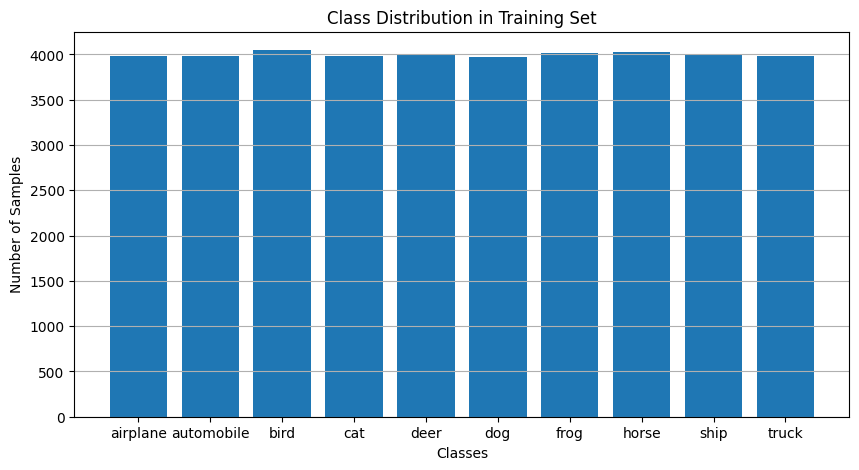


Sample data:


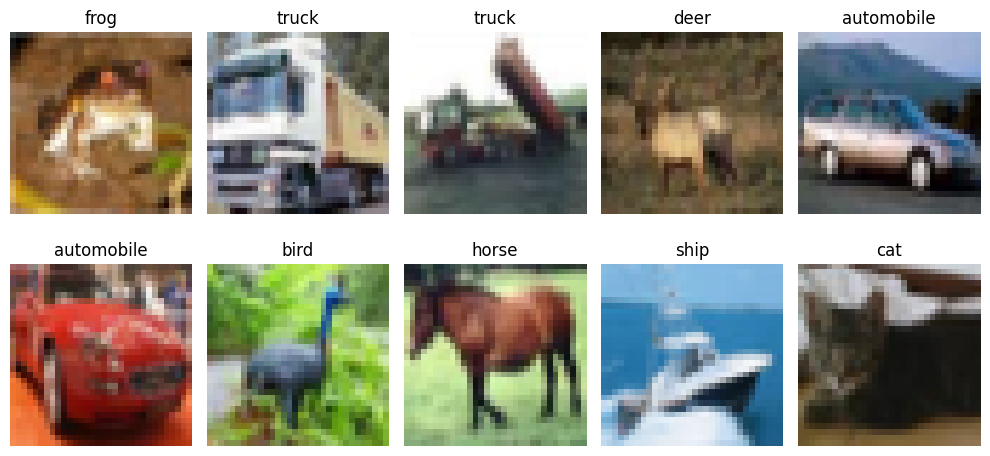

Image dimensions: Height=32, Width=32


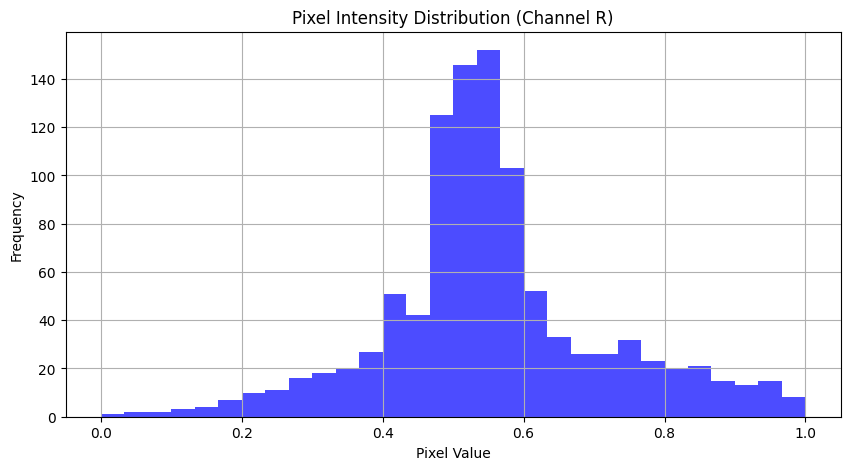

Sample image pixel statistics (Channel R):
Mean: 0.55
Median: 0.54
Max: 1.0


In [4]:
from data_preprocessing import load_cifar10_data

# Load CIFAR-10 dataset
(x_train, y_train), (x_val, y_val), (x_test, y_test), class_names = load_cifar10_data()

# Print dataset sizes and class distribution
print(f"Dataset sizes: Train={len(x_train)}, Valid={len(x_val)}, Test={len(x_test)}")
print(f"Classes in dataset: {class_names}")
print(f"Train label distribution: {np.bincount(y_train)}")
print(f"Validation label distribution: {np.bincount(y_val)}")
print(f"Test label distribution: {np.bincount(y_test)}")

# Visualisasi distribusi kelas dalam dataset pelatihan
plt.figure(figsize=(10, 5))
train_class_counts = np.bincount(y_train)
plt.bar(class_names, train_class_counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.grid(axis='y')
plt.show()

# Menampilkan beberapa contoh gambar dari dataset
print("\nSample data:")
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Visualisasi dimensi citra gambar
image_heights = [img.shape[0] for img in x_train]
image_widths = [img.shape[1] for img in x_train]
print(f"Image dimensions: Height={image_heights[0]}, Width={image_widths[0]}")

# Visualisasi distribusi pixel citra gambar
sample_image = x_train[0]
pixel_values = sample_image[:, :, 0].flatten()  # Choose one channel (e.g., R in RGB)
plt.figure(figsize=(10, 5))
plt.hist(pixel_values, bins=30, color='blue', alpha=0.7)
plt.title('Pixel Intensity Distribution (Channel R)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display mean, median, and max values for pixel intensities
print(f"Sample image pixel statistics (Channel R):")
print(f"Mean: {np.mean(pixel_values):.2f}")
print(f"Median: {np.median(pixel_values):.2f}")
print(f"Max: {np.max(pixel_values)}")


# 2 Model CNN

Pada bagian ini, kita akan membuat serta melatih model CNN untuk melakukan klasifikasi gambar.

After Conv Layer 1, output shape: (None, 30, 30, 32)
After Conv Layer 2, output shape: (None, 13, 13, 64)

Training basic_cnn...
Epoch 1/10
1405/1407 [============================>.] - ETA: 0s - loss: 1.5037 - accuracy: 0.4599
Epoch 1: val_loss improved from inf to 1.19848, saving model to checkpoints\basic_cnn.weights.h5
1407/1407 [==============================] - 29s 20ms/step - loss: 1.5036 - accuracy: 0.4600 - val_loss: 1.1985 - val_accuracy: 0.5768 - lr: 0.0010
Epoch 2/10
1407/1407 [==============================] - ETA: 0s - loss: 1.1313 - accuracy: 0.6021
Epoch 2: val_loss improved from 1.19848 to 1.04091, saving model to checkpoints\basic_cnn.weights.h5
1407/1407 [==============================] - 29s 21ms/step - loss: 1.1313 - accuracy: 0.6021 - val_loss: 1.0409 - val_accuracy: 0.6460 - lr: 0.0010
Epoch 3/10
1407/1407 [==============================] - ETA: 0s - loss: 0.9910 - accuracy: 0.6550
Epoch 3: val_loss improved from 1.04091 to 0.98346, saving model to checkpoints\bas

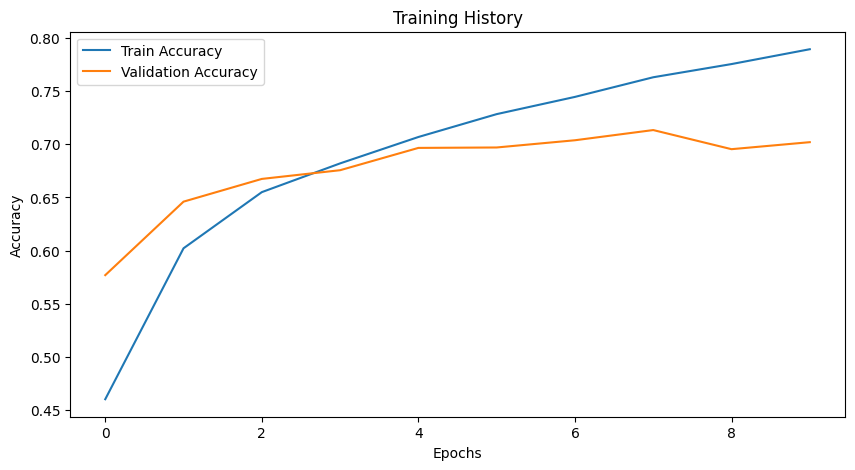

Test Loss: 0.9071
Test Accuracy: 0.6972
Test F1 Score: 0.7003


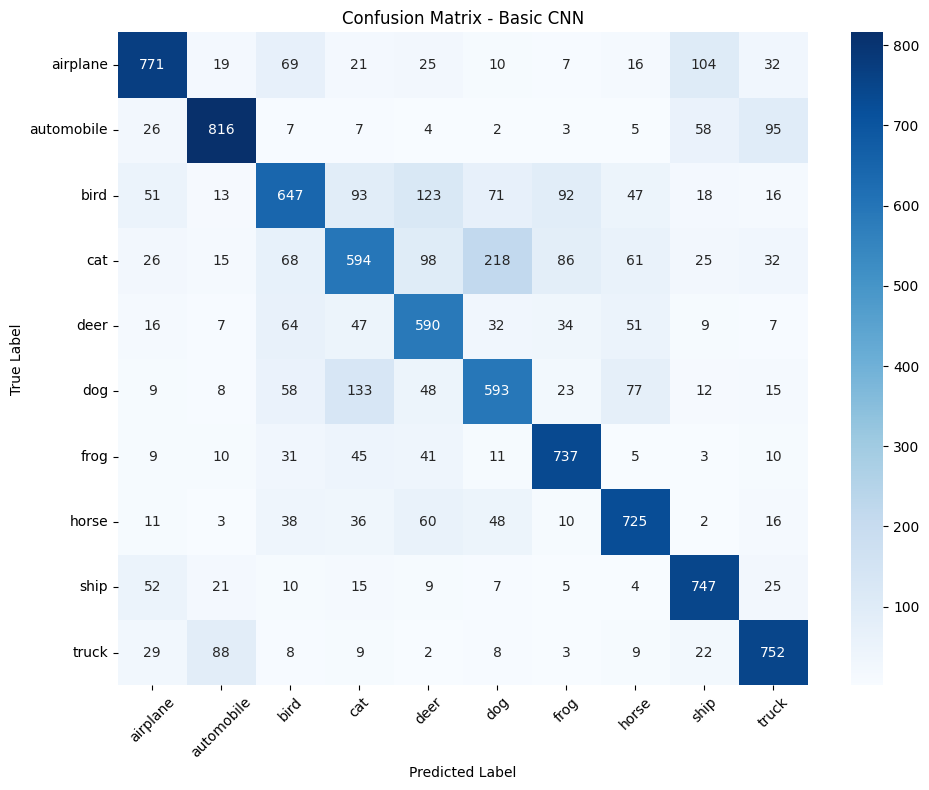


Classification Report:
              precision    recall  f1-score   support

    airplane       0.72      0.77      0.74      1000
  automobile       0.80      0.82      0.81      1000
        bird       0.55      0.65      0.60      1000
         cat       0.49      0.59      0.53      1000
        deer       0.69      0.59      0.64      1000
         dog       0.61      0.59      0.60      1000
        frog       0.82      0.74      0.77      1000
       horse       0.76      0.72      0.74      1000
        ship       0.83      0.75      0.79      1000
       truck       0.81      0.75      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



In [4]:
# Dataset CIFAR-10
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Normalisasi data
train_images, test_images = train_images / 255.0, test_images / 255.0

# Split validasi
valid_images = train_images[-5000:]
valid_labels = train_labels[-5000:]
train_images = train_images[:-5000]
train_labels = train_labels[:-5000]

# Buat model CNN dengan parameter default (model dasar)
model_cnn = create_cnn_model()

# Latih model menggunakan fungsi train_and_evaluate_model yang baru
model_cnn, history, test_f1 = train_and_evaluate_model(
    model=model_cnn,
    x_train=train_images,
    y_train=train_labels,
    x_val=valid_images,
    y_val=valid_labels,
    x_test=test_images,
    y_test=test_labels,
    model_name="basic_cnn",
    epochs=10
)

# Plot kurva training
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluasi model untuk mendapatkan metrik lengkap
test_loss, test_accuracy = model_cnn.evaluate(test_images, test_labels, verbose=0)
test_predictions = model_cnn.predict(test_images, verbose=0)

# Tampilkan metrik evaluasi
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Siapkan data untuk confusion matrix dan classification report
preds_cnn = np.argmax(test_predictions, axis=1)
labels_cnn = test_labels.flatten()

# Plot confusion matrix (jika fungsi tersedia)
try:
    plot_confusion_matrix(preds_cnn, labels_cnn, class_names, "Basic CNN")
except NameError:
    print("plot_confusion_matrix function not available")

# Tampilkan classification report
print("\nClassification Report:")
print(classification_report(labels_cnn, preds_cnn, target_names=class_names))

# 3. Eksperimen Variasi Parameter

Di bagian ini kita melakukan eksperimen untuk menguji pengaruh:
1. Jumlah layer konvolusi
2. Banyak filter per layer konvolusi
3. Ukuran filter per layer konvolusi
4. Jenis pooling layer

## 3.1 Eksperimen Jumlah Layer Konvolusi
3 variasi jumlah layer Konvolusi: 1, 2, dan 3 layer.


EXPERIMENT 1: EFFECT OF NUMBER OF CONVOLUTIONAL LAYERS
Training set: (40000, 32, 32, 3), (40000,)
Validation set: (10000, 32, 32, 3), (10000,)
Test set: (10000, 32, 32, 3), (10000,)

Training Model: 1_layers
After Conv Layer 1, output shape: (None, 30, 30, 32)

Model Architecture - 1_layers:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                460864    
                        

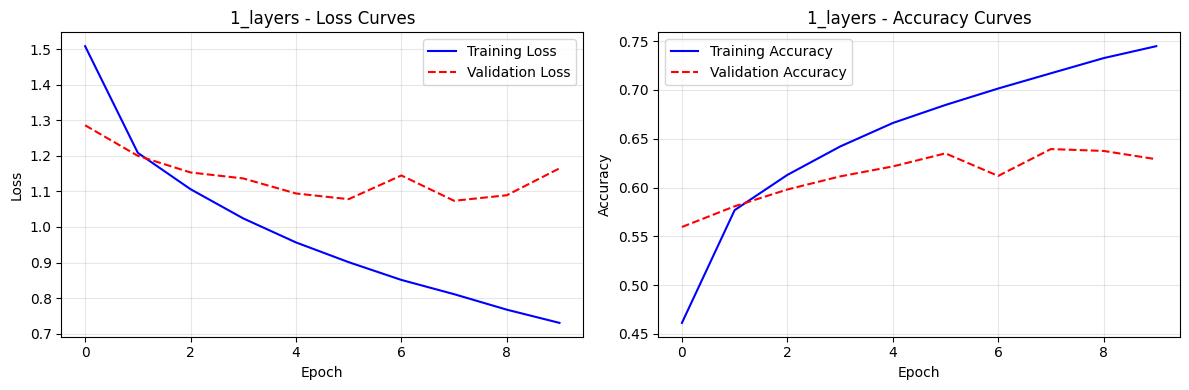


🔍 Confusion Matrix for 1_layers:


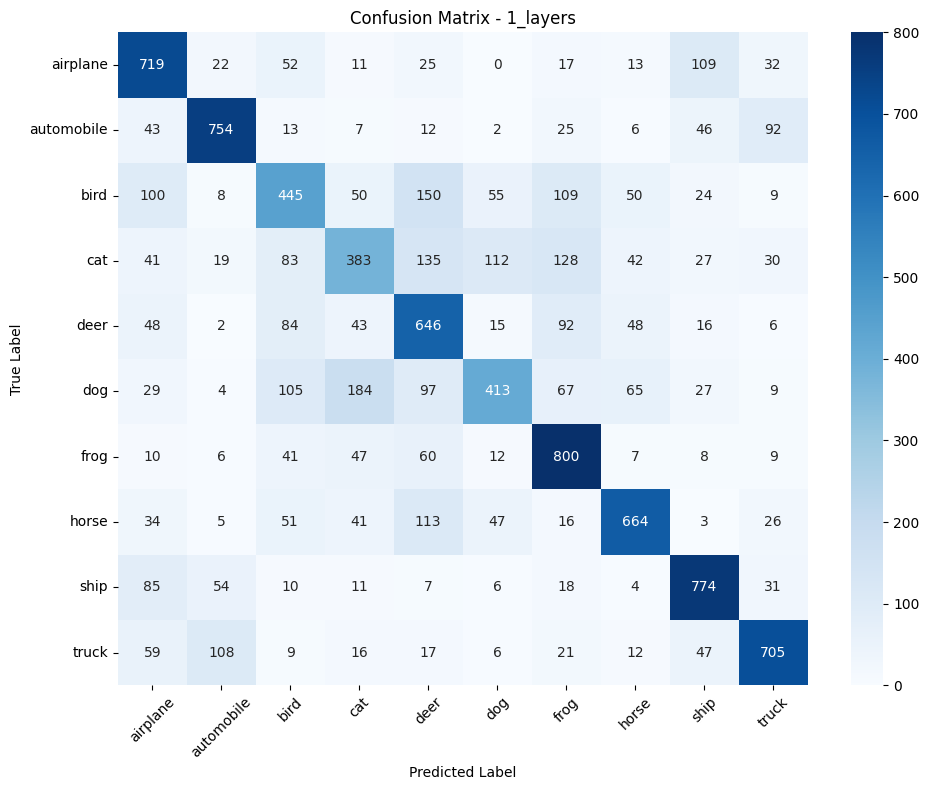

\nResults for 1_layers:
Test Accuracy: 0.6303
Test F1-Score: 0.6248
Test Loss: 1.0754
Training Time: 193.11 seconds

Training Model: 2_layers
After Conv Layer 1, output shape: (None, 30, 30, 32)
After Conv Layer 2, output shape: (None, 13, 13, 64)

Model Architecture - 2_layers:
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                  

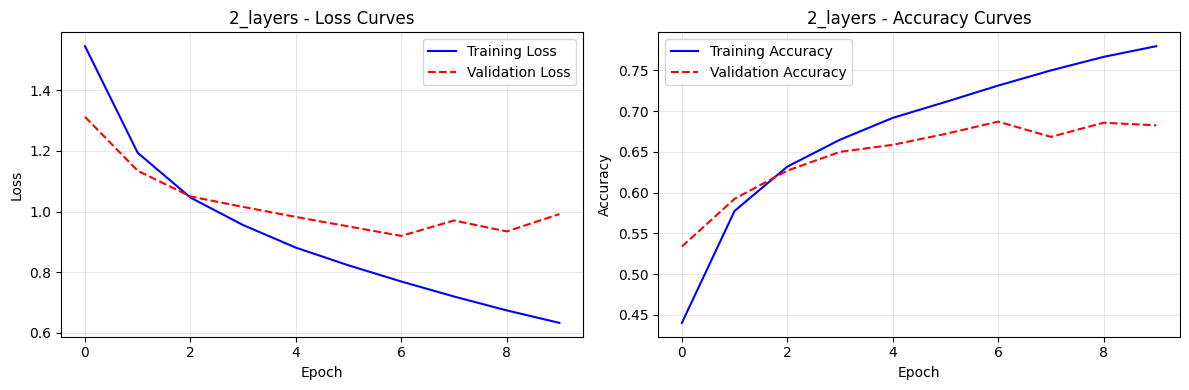


🔍 Confusion Matrix for 2_layers:


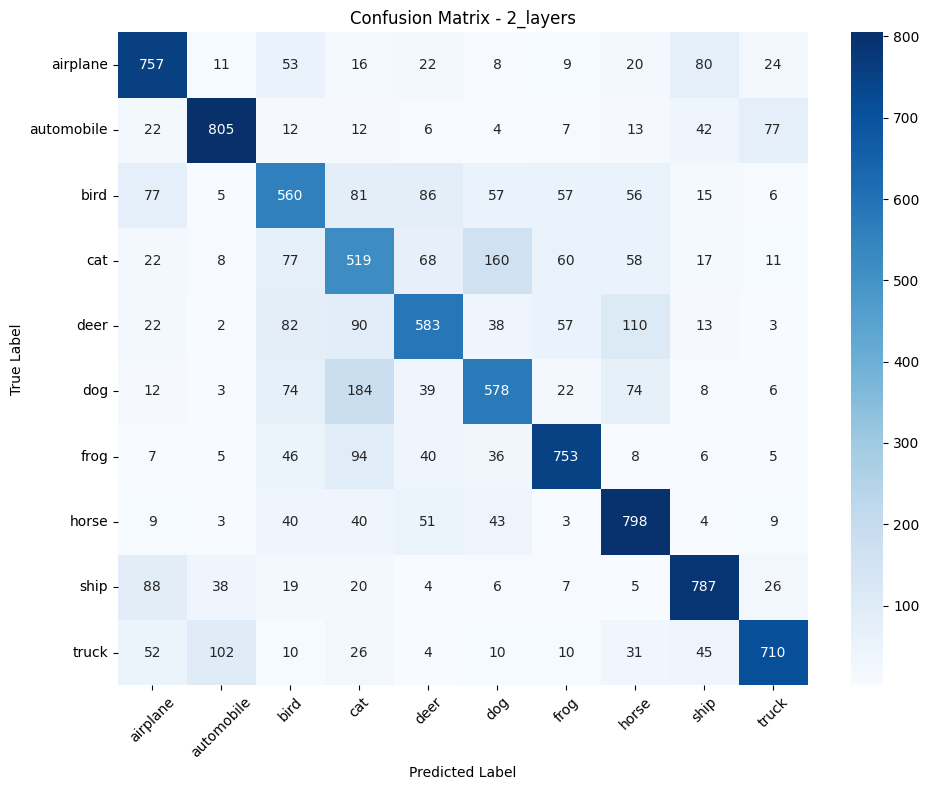

\nResults for 2_layers:
Test Accuracy: 0.6850
Test F1-Score: 0.6849
Test Loss: 0.9222
Training Time: 287.75 seconds

Training Model: 3_layers
After Conv Layer 1, output shape: (None, 30, 30, 32)
After Conv Layer 2, output shape: (None, 13, 13, 64)
After Conv Layer 3, output shape: (None, 4, 4, 128)

Model Architecture - 3_layers:
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)      

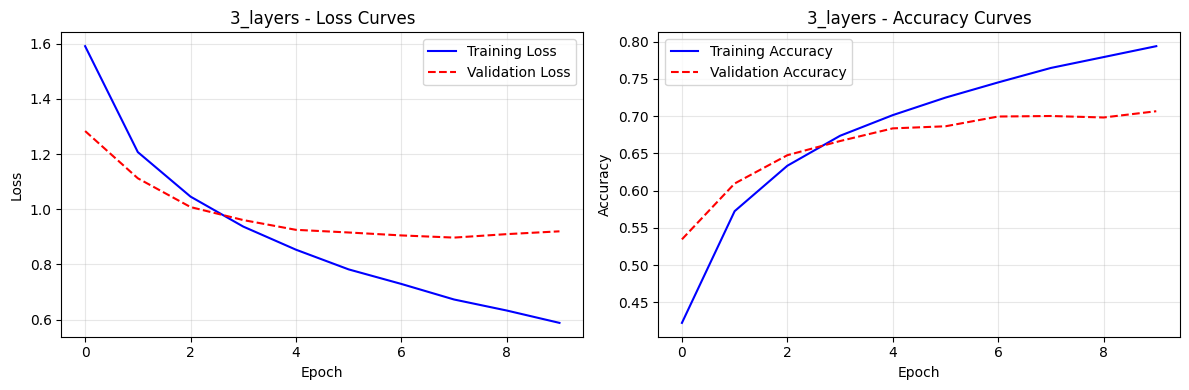


🔍 Confusion Matrix for 3_layers:


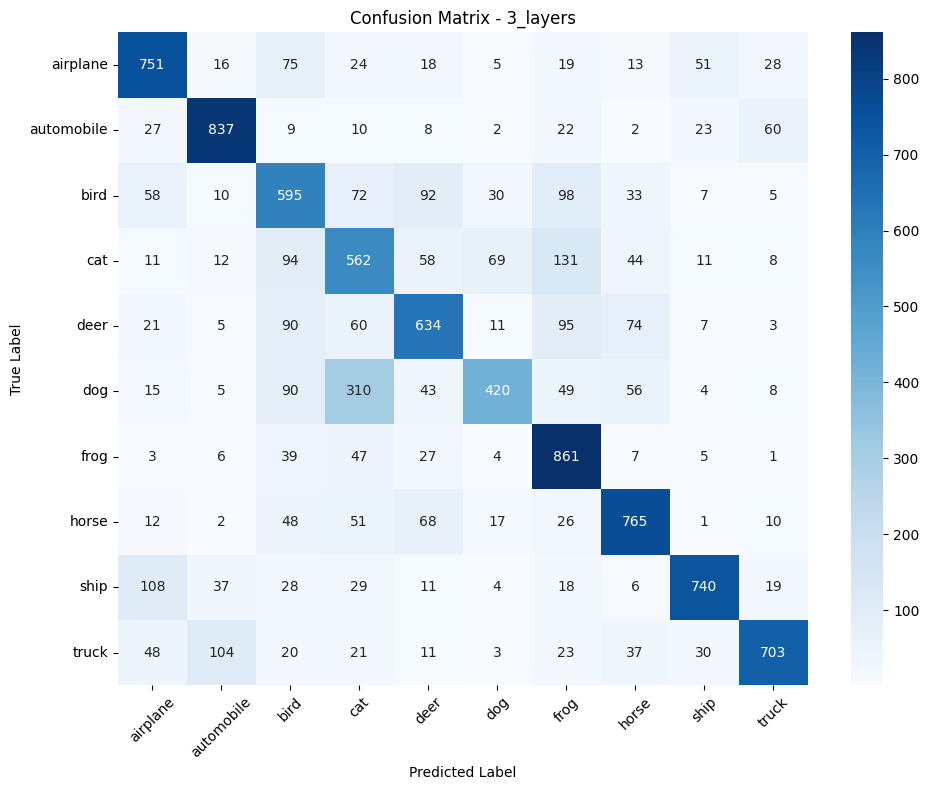

\nResults for 3_layers:
Test Accuracy: 0.6868
Test F1-Score: 0.6855
Test Loss: 0.9260
Training Time: 318.27 seconds

📈 Combined Comparison of All Models:


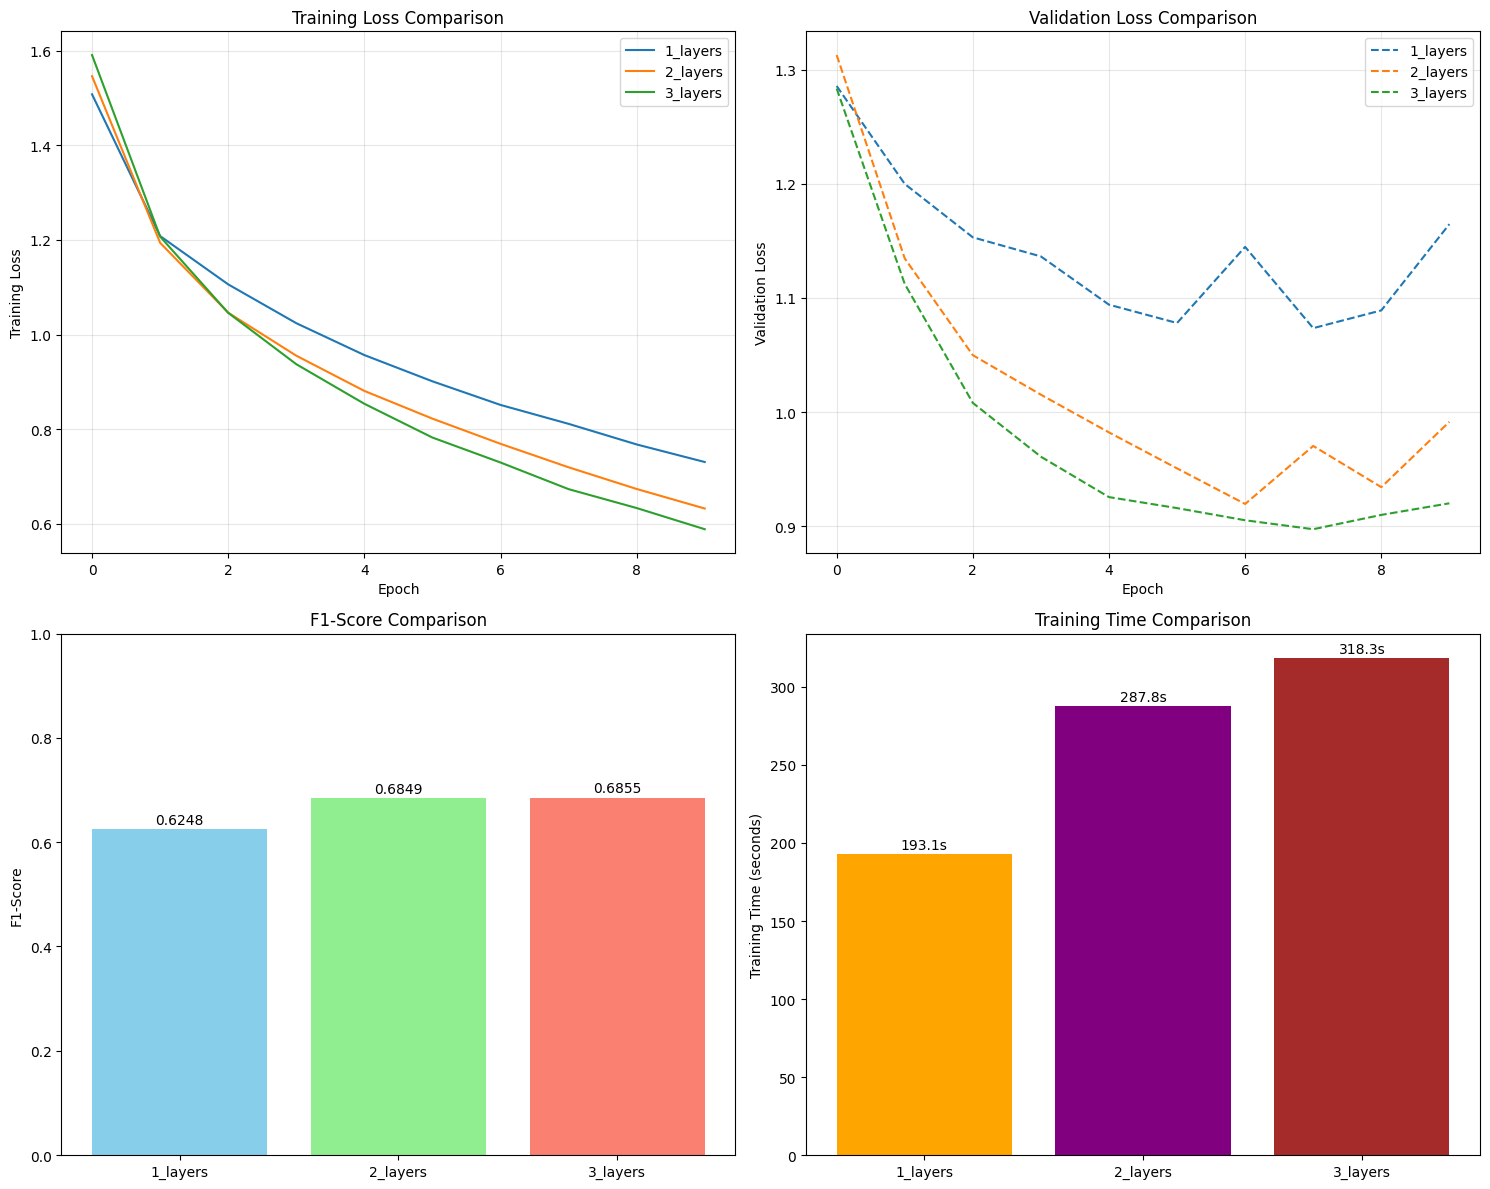

Results saved to experiment_results/conv_layers_experiment_results.csv

EXPERIMENT RESULTS SUMMARY
 num_layers  accuracy  f1_score     loss  train_time
          1    0.6303  0.624790 1.075391  193.111373
          2    0.6850  0.684929 0.922217  287.753189
          3    0.6868  0.685485 0.925977  318.266408

Best Model: 3_layers
Best F1-Score: 0.6855
Best Accuracy: 0.6868


In [8]:
def experiment_conv_layers():
    """Experiment with different numbers of convolutional layers"""
    print("\n" + "="*60)
    print("EXPERIMENT 1: EFFECT OF NUMBER OF CONVOLUTIONAL LAYERS")
    print("="*60)
    
    # Load data
    (x_train, y_train), (x_val, y_val), (x_test, y_test), class_names = load_cifar10_data()
    
    # Layer Konvolusi yang akan dieksperimen
    conv_layer_configs = [
        (1, [32], [3]), # 1 layer
        (2, [32, 64], [3, 3]), # 2 layers
        (3, [32, 64, 128], [3, 3, 3]), # 3 layers
    ]
    
    models_list = []
    histories = []
    model_names = []
    f1_scores = []
    train_times = []
    accuracies = []
    final_losses = []
    
    # Buat direktori untuk menyimpan model dan hasil dan CSV
    os.makedirs('results', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    
    for i, (num_layers, filters, kernels) in enumerate(conv_layer_configs):
        model_name = f"{num_layers}_layers"
        print(f"\n{'='*50}")
        print(f"Training Model: {model_name}")
        print(f"{'='*50}")
        
        model = create_cnn_model(
            conv_layers=num_layers,
            filters_per_layer=filters,
            kernel_sizes=kernels
        )
        
        # Print model summary
        print(f"\nModel Architecture - {model_name}:")
        model.summary()
        
        # Record waktu mulai
        start_time = time.time()
        
        # Latih dan evaluasi model
        trained_model, history, f1_score = train_and_evaluate_model(
            model, x_train, y_train, x_val, y_val, x_test, y_test, 
            model_name, epochs=10
        )
        
        # Record waktu selesai
        end_time = time.time()
        train_time = end_time - start_time
        
        # Dapatkan akurasi dan loss akhir pada data uji
        test_loss, test_accuracy = trained_model.evaluate(x_test, y_test, verbose=0)
        
        # Simpan hasil
        models_list.append(trained_model)
        histories.append(history)
        model_names.append(model_name)
        f1_scores.append(f1_score)
        train_times.append(train_time)
        accuracies.append(test_accuracy)
        final_losses.append(test_loss)
        
        # Simpan model ke file
        trained_model.save(f'models/cnn_{model_name}.keras')
        
        # Plot individual training history
        print(f"\n📊 Training Curves for {model_name}:")
        plot_individual_training_history(history, model_name)
        
        # Generasi dan tampilkan confusion matrix
        test_predictions = trained_model.predict(x_test, verbose=0)
        y_pred = np.argmax(test_predictions, axis=1)
        
        print(f"\n🔍 Confusion Matrix for {model_name}:")
        plot_confusion_matrix(y_test, y_pred, class_names, model_name)
        
        print(f"\\nResults for {model_name}:")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1-Score: {f1_score:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Training Time: {train_time:.2f} seconds")
    
    # Komparasi semua model
    print(f"\n📈 Combined Comparison of All Models:")
    plot_combined_comparison(histories, model_names, f1_scores, train_times)
    
    # Simpan hasil ke CSV
    results_dir = 'experiment_results'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    results_df = save_results_to_csv_conv(
        model_names, accuracies, f1_scores, final_losses, train_times,
        'experiment_results/conv_layers_experiment_results.csv'
    )
    
    # Print hasil eksperimen
    print(f"\n{'='*60}")
    print("EXPERIMENT RESULTS SUMMARY")
    print(f"{'='*60}")
    print(results_df.to_string(index=False))
    
    # Print model terbaik berdasarkan F1-Score
    best_f1_idx = np.argmax(f1_scores)
    print(f"\nBest Model: {model_names[best_f1_idx]}")
    print(f"Best F1-Score: {f1_scores[best_f1_idx]:.4f}")
    print(f"Best Accuracy: {accuracies[best_f1_idx]:.4f}")
    
    return models_list, histories, model_names, f1_scores

conv_layer_models, conv_layer_histories, conv_layer_names, conv_layer_scores = experiment_conv_layers()

## 3.2 Eksperimen Banyak Filter per Layer Konvolusi
3 variasi banyak filter per layer konvolusi:
1. 16, 32, 64
2. 32, 64, 128
3. 64, 128, 256


EXPERIMENT 2: EFFECT OF NUMBER OF FILTERS PER LAYER
Training set: (40000, 32, 32, 3), (40000,)
Validation set: (10000, 32, 32, 3), (10000,)
Test set: (10000, 32, 32, 3), (10000,)

Training Model: filters_16_32_64
After Conv Layer 1, output shape: (None, 30, 30, 16)
After Conv Layer 2, output shape: (None, 13, 13, 32)
After Conv Layer 3, output shape: (None, 4, 4, 64)

Model Architecture - filters_16_32_64:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        4640      
                                       

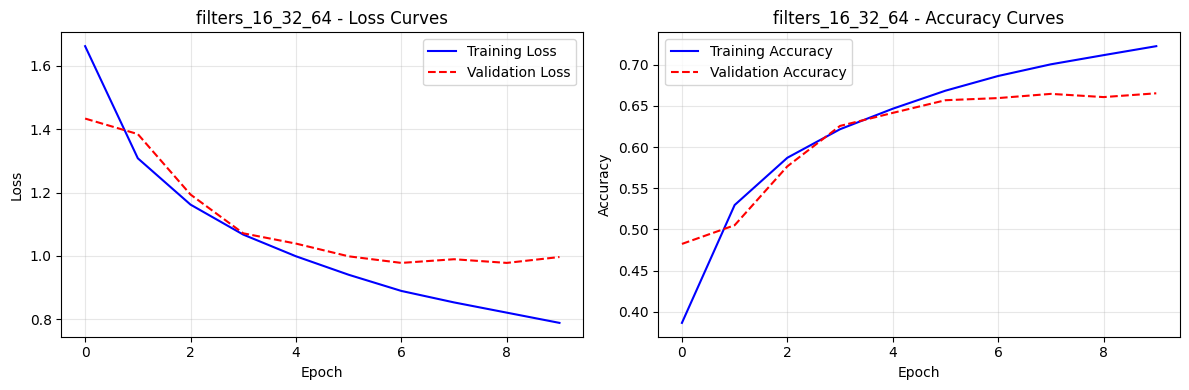


🔍 Confusion Matrix for filters_16_32_64:


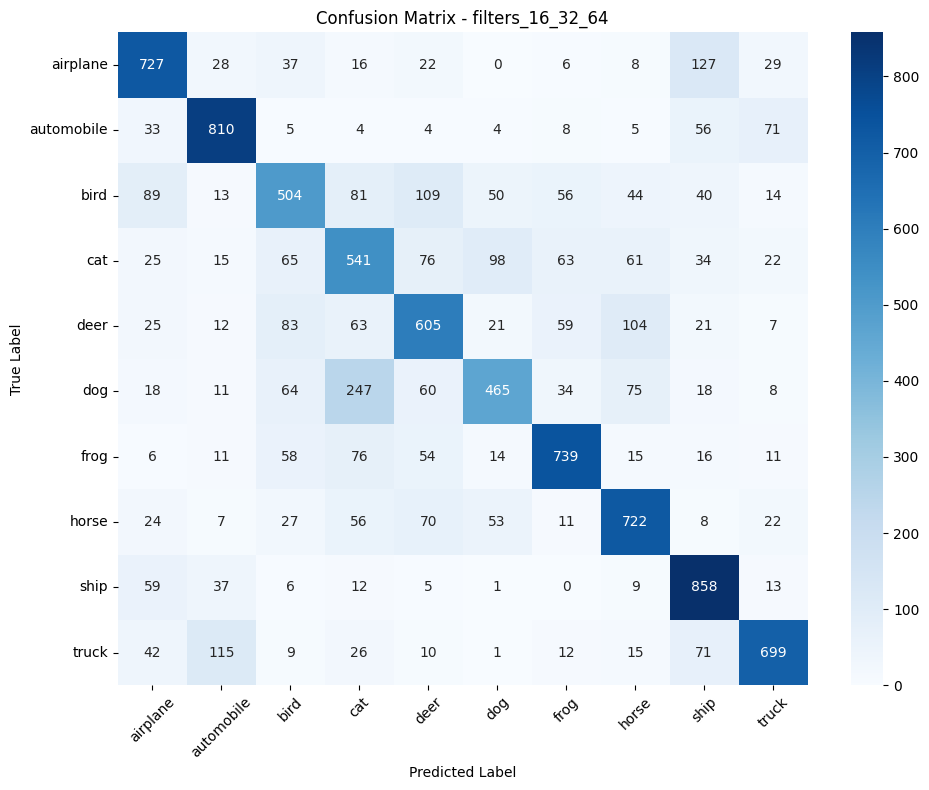


Results for filters_16_32_64:
Test Accuracy: 0.6670
Test F1-Score: 0.6640
Test Loss: 0.9760
Training Time: 161.23 seconds

Training Model: filters_32_64_128
After Conv Layer 1, output shape: (None, 30, 30, 32)
After Conv Layer 2, output shape: (None, 13, 13, 64)
After Conv Layer 3, output shape: (None, 4, 4, 128)

Model Architecture - filters_32_64_128:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin

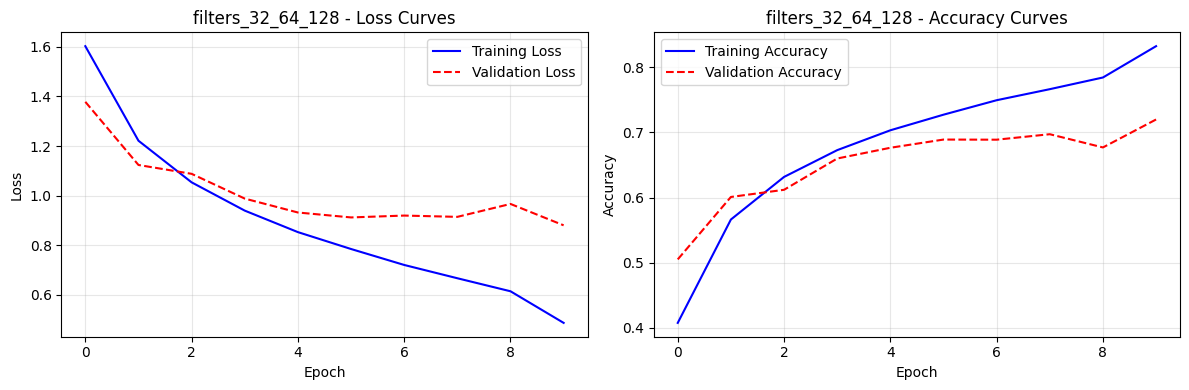


🔍 Confusion Matrix for filters_32_64_128:


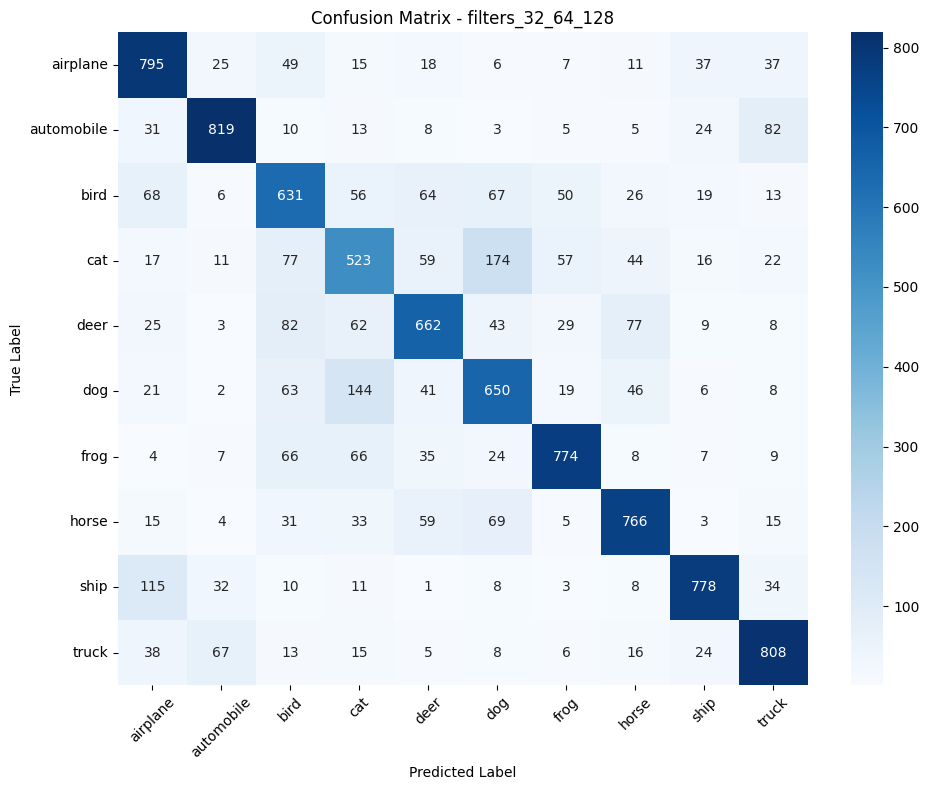


Results for filters_32_64_128:
Test Accuracy: 0.7206
Test F1-Score: 0.7206
Test Loss: 0.8884
Training Time: 280.32 seconds

Training Model: filters_64_128_256
After Conv Layer 1, output shape: (None, 30, 30, 64)
After Conv Layer 2, output shape: (None, 13, 13, 128)
After Conv Layer 3, output shape: (None, 4, 4, 256)

Model Architecture - filters_64_128_256:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPo

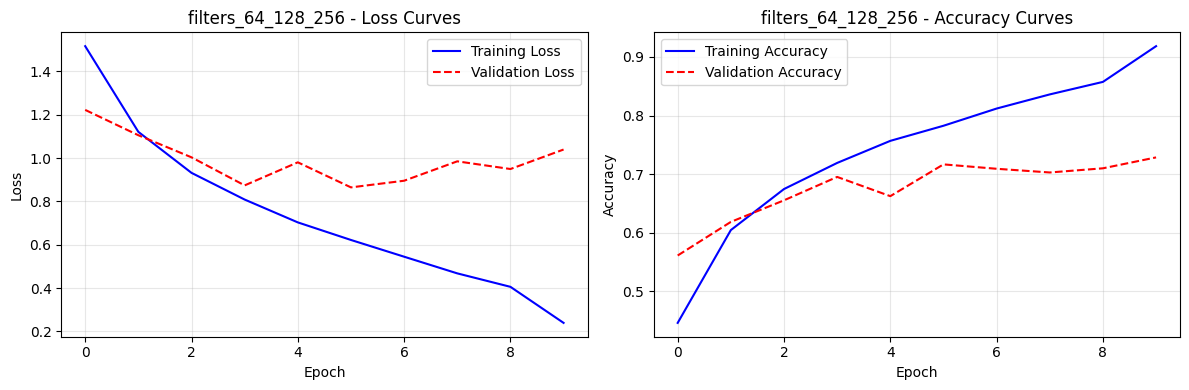


🔍 Confusion Matrix for filters_64_128_256:


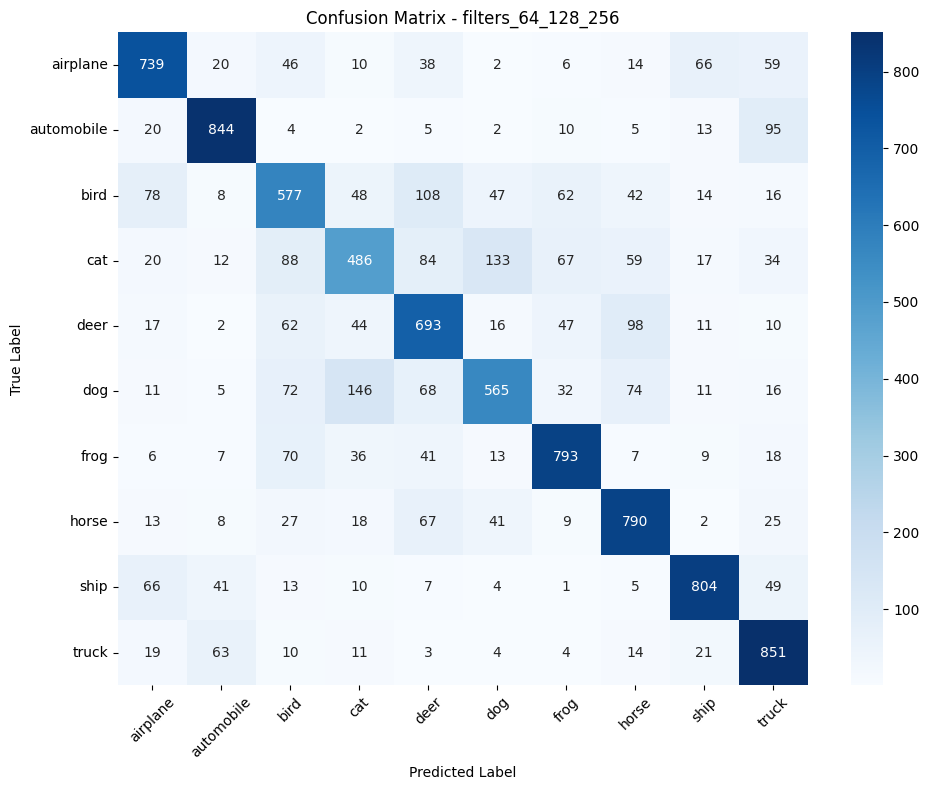


Results for filters_64_128_256:
Test Accuracy: 0.7142
Test F1-Score: 0.7111
Test Loss: 0.8650
Training Time: 516.29 seconds

📈 Combined Comparison of All Models:


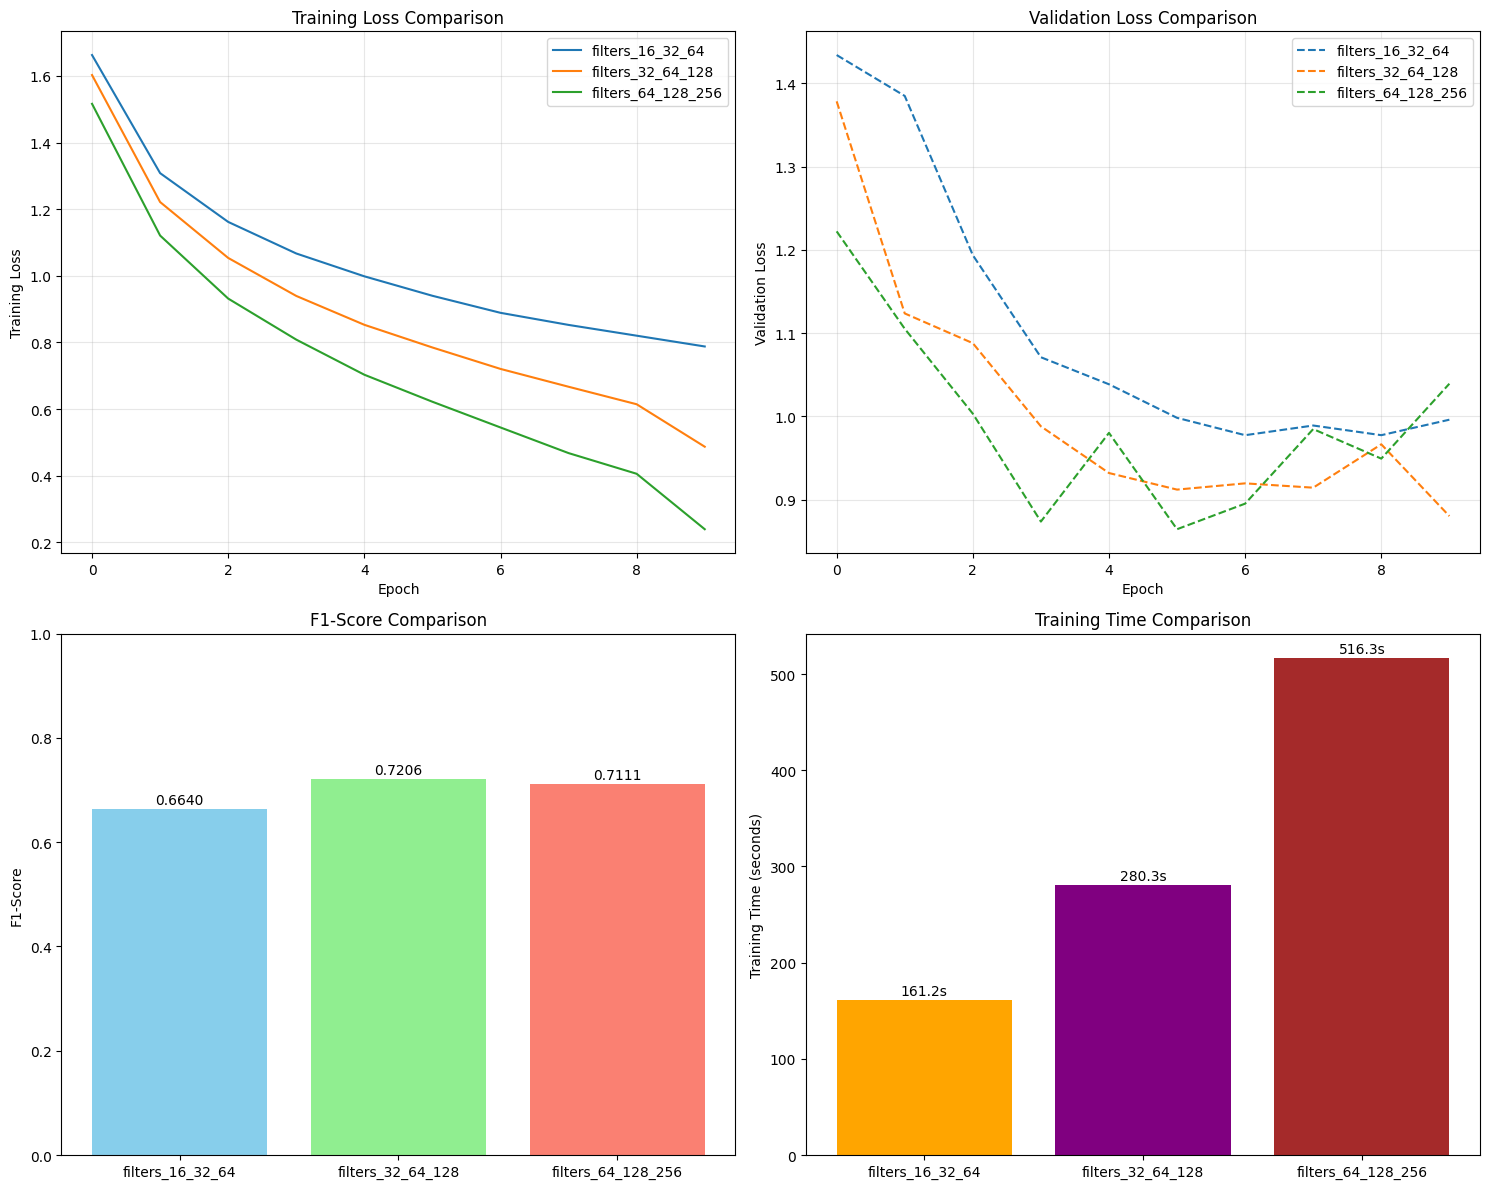

Results saved to experiment_results/filter_numbers_experiment_results.csv

EXPERIMENT RESULTS SUMMARY
filter_config  accuracy  f1_score     loss  train_time
     16-32-64    0.6670  0.663994 0.975955  161.230442
    32-64-128    0.7206  0.720639 0.888435  280.319793
   64-128-256    0.7142  0.711057 0.864992  516.288479

Best Model: filters_32_64_128
Best F1-Score: 0.7206
Best Accuracy: 0.7206


In [ ]:
def experiment_filter_numbers():
    """Experiment with different numbers of filters per layer"""
    print("\n" + "="*60)
    print("EXPERIMENT 2: EFFECT OF NUMBER OF FILTERS PER LAYER")
    print("="*60)
    
    # Load data
    # Muat data
    (x_train, y_train), (x_val, y_val), (x_test, y_test), class_names = load_cifar10_data()
    
    # Konfigurasi filter yang akan dieksperimen
    filter_configs = [
        [16, 32, 64],    # Filter kecil
        [32, 64, 128],   # Filter medium
        [64, 128, 256]   # Filter besar
    ]
    
    models_list = []
    histories = []
    model_names = []
    f1_scores = []
    train_times = []
    accuracies = []
    final_losses = []
    
    os.makedirs('experiment_results', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    
    for i, filters in enumerate(filter_configs):
        model_name = f"filters_{filters[0]}_{filters[1]}_{filters[2]}"
        print(f"\n{'='*50}")
        print(f"Training Model: {model_name}")
        print(f"{'='*50}")
        
        # Gunakan fungsi pembuatan model CNN dengan filter yang ditentukan
        model = create_cnn_model(
            conv_layers=3,
            filters_per_layer=filters,
            kernel_sizes=[3, 3, 3]
        )
        
        # Print arsitektur model
        print(f"\nModel Architecture - {model_name}:")
        model.summary()
        
        # Record waktu mulai
        start_time = time.time()
        
        # Train dan evaluasi model
        trained_model, history, f1_score = train_and_evaluate_model(
            model, x_train, y_train, x_val, y_val, x_test, y_test, 
            model_name, epochs=10
        )
        
        # Record waktu selesai
        end_time = time.time()
        train_time = end_time - start_time
        
        # Dapatkan akurasi dan loss akhir pada data uji
        test_loss, test_accuracy = trained_model.evaluate(x_test, y_test, verbose=0)
        
        # Simpan hasil
        models_list.append(trained_model)
        histories.append(history)
        model_names.append(model_name)
        f1_scores.append(f1_score)
        train_times.append(train_time)
        accuracies.append(test_accuracy)
        final_losses.append(test_loss)
        
        # Simpan model ke file
        trained_model.save(f'models/cnn_{model_name}.keras')

        # Tampilkan kurva training
        print(f"\n📊 Training Curves for {model_name}:")
        plot_individual_training_history(history, model_name)
        
        # Generate dan tampilkan confusion matrix
        test_predictions = trained_model.predict(x_test, verbose=0)
        y_pred = np.argmax(test_predictions, axis=1)
        
        print(f"\n🔍 Confusion Matrix for {model_name}:")
        plot_confusion_matrix(y_test, y_pred, class_names, model_name)
        
        print(f"\nResults for {model_name}:")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1-Score: {f1_score:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Training Time: {train_time:.2f} seconds")
    
    # Tampilkan perbandingan semua model
    print(f"\n📈 Combined Comparison of All Models:")
    plot_combined_comparison(histories, model_names, f1_scores, train_times)
    
    # Simpan hasil ke CSV
    results_df = save_results_to_csv_filters(
        model_names, accuracies, f1_scores, final_losses, train_times,
        'experiment_results/filter_numbers_experiment_results.csv'
    )
    
    # Print hasil eksperimen
    print(f"\n{'='*60}")
    print("EXPERIMENT RESULTS SUMMARY")
    print(f"{'='*60}")
    print(results_df.to_string(index=False))
    
    # Print model terbaik berdasarkan F1-Score
    best_f1_idx = np.argmax(f1_scores)
    print(f"\nBest Model: {model_names[best_f1_idx]}")
    print(f"Best F1-Score: {f1_scores[best_f1_idx]:.4f}")
    print(f"Best Accuracy: {accuracies[best_f1_idx]:.4f}")
    
    return models_list, histories, model_names, f1_scores

filter_models, filter_histories, filter_names, filter_scores = experiment_filter_numbers()

## 3.3 Eksperimen Ukuran Filter per Layer Konvolusi
2 variasi pooling layer:
1. Semua kernel 3x3
2. Dimulai dengan kernel besar, lalu kecil
3. Ukuran campuran


EXPERIMENT 3: EFFECT OF KERNEL SIZES
Training set: (40000, 32, 32, 3), (40000,)
Validation set: (10000, 32, 32, 3), (10000,)
Test set: (10000, 32, 32, 3), (10000,)

Training Model: kernels_3x3x3
After Conv Layer 1, output shape: (None, 30, 30, 32)
After Conv Layer 2, output shape: (None, 13, 13, 64)
After Conv Layer 3, output shape: (None, 4, 4, 128)

Model Architecture - kernels_3x3x3:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                           

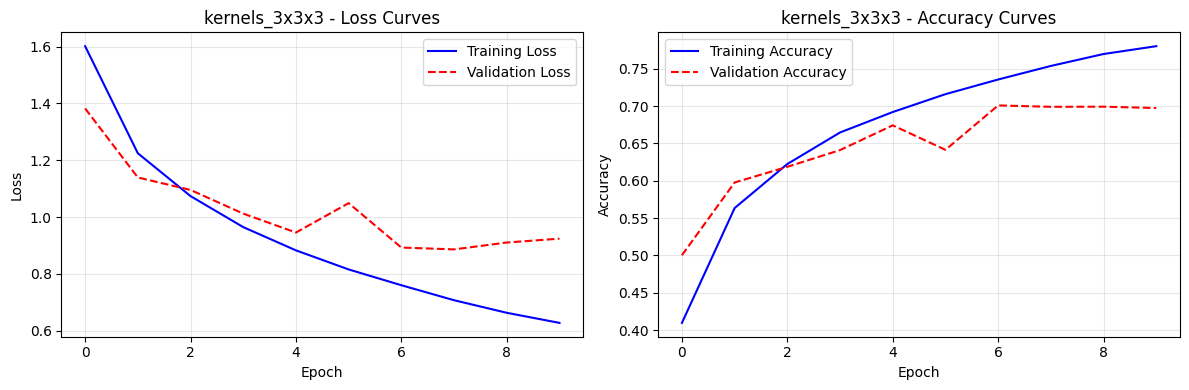


🔍 Confusion Matrix for kernels_3x3x3:


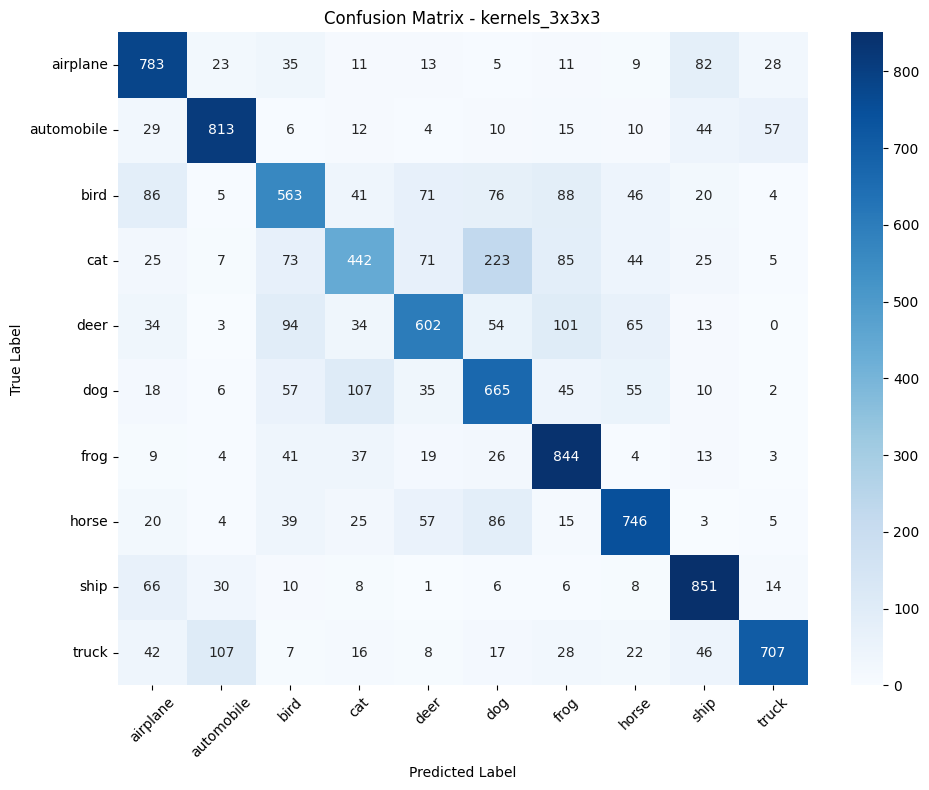


Results for kernels_3x3x3:
Test Accuracy: 0.7016
Test F1-Score: 0.6982
Test Loss: 0.8953
Training Time: 301.04 seconds

Training Model: kernels_4x3x3
After Conv Layer 1, output shape: (None, 29, 29, 32)
After Conv Layer 2, output shape: (None, 12, 12, 64)
After Conv Layer 3, output shape: (None, 4, 4, 128)

Model Architecture - kernels_4x3x3:
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        1568      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6

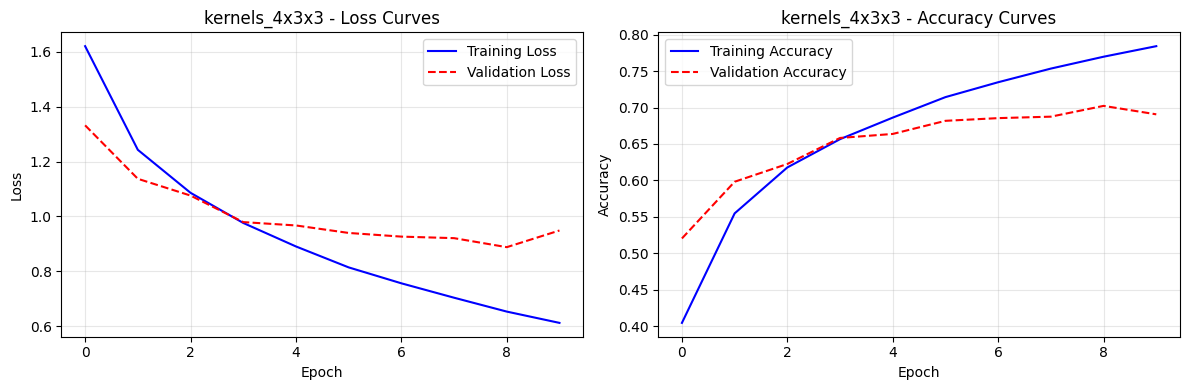


🔍 Confusion Matrix for kernels_4x3x3:


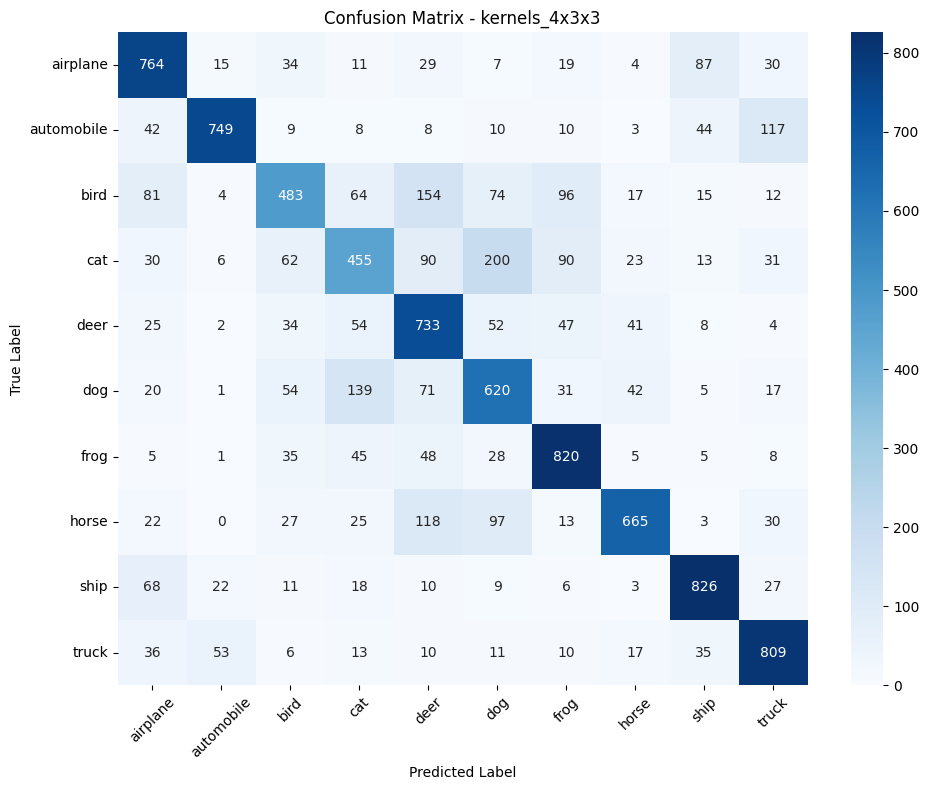


Results for kernels_4x3x3:
Test Accuracy: 0.6924
Test F1-Score: 0.6901
Test Loss: 0.9242
Training Time: 281.23 seconds

Training Model: kernels_3x4x5
After Conv Layer 1, output shape: (None, 30, 30, 32)
After Conv Layer 2, output shape: (None, 12, 12, 64)
After Conv Layer 3, output shape: (None, 2, 2, 128)

Model Architecture - kernels_3x4x5:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6

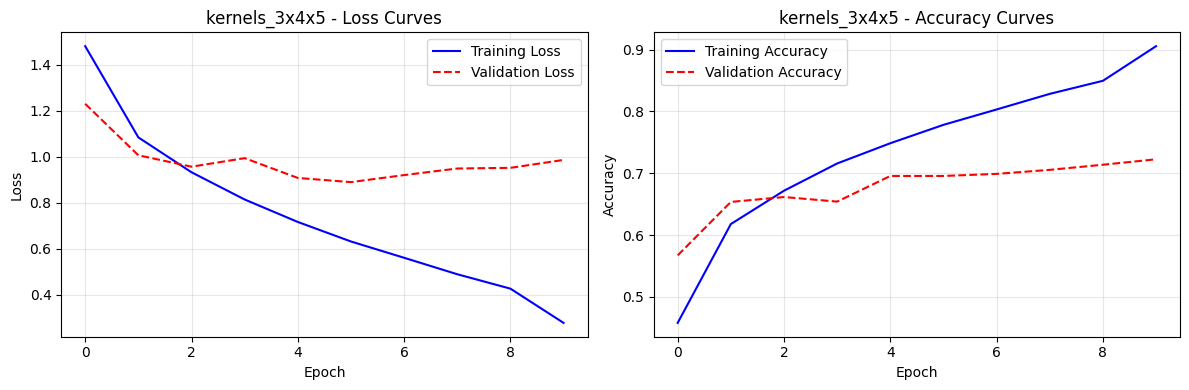


🔍 Confusion Matrix for kernels_3x4x5:


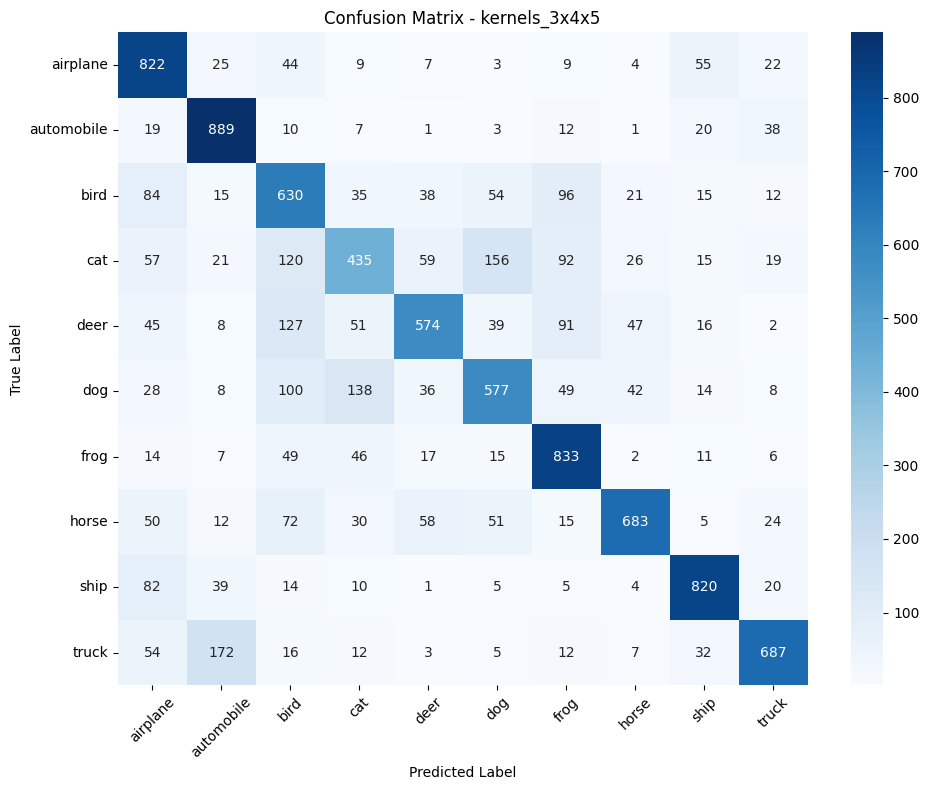


Results for kernels_3x4x5:
Test Accuracy: 0.6950
Test F1-Score: 0.6914
Test Loss: 0.9104
Training Time: 308.11 seconds

📈 Combined Comparison of All Models:


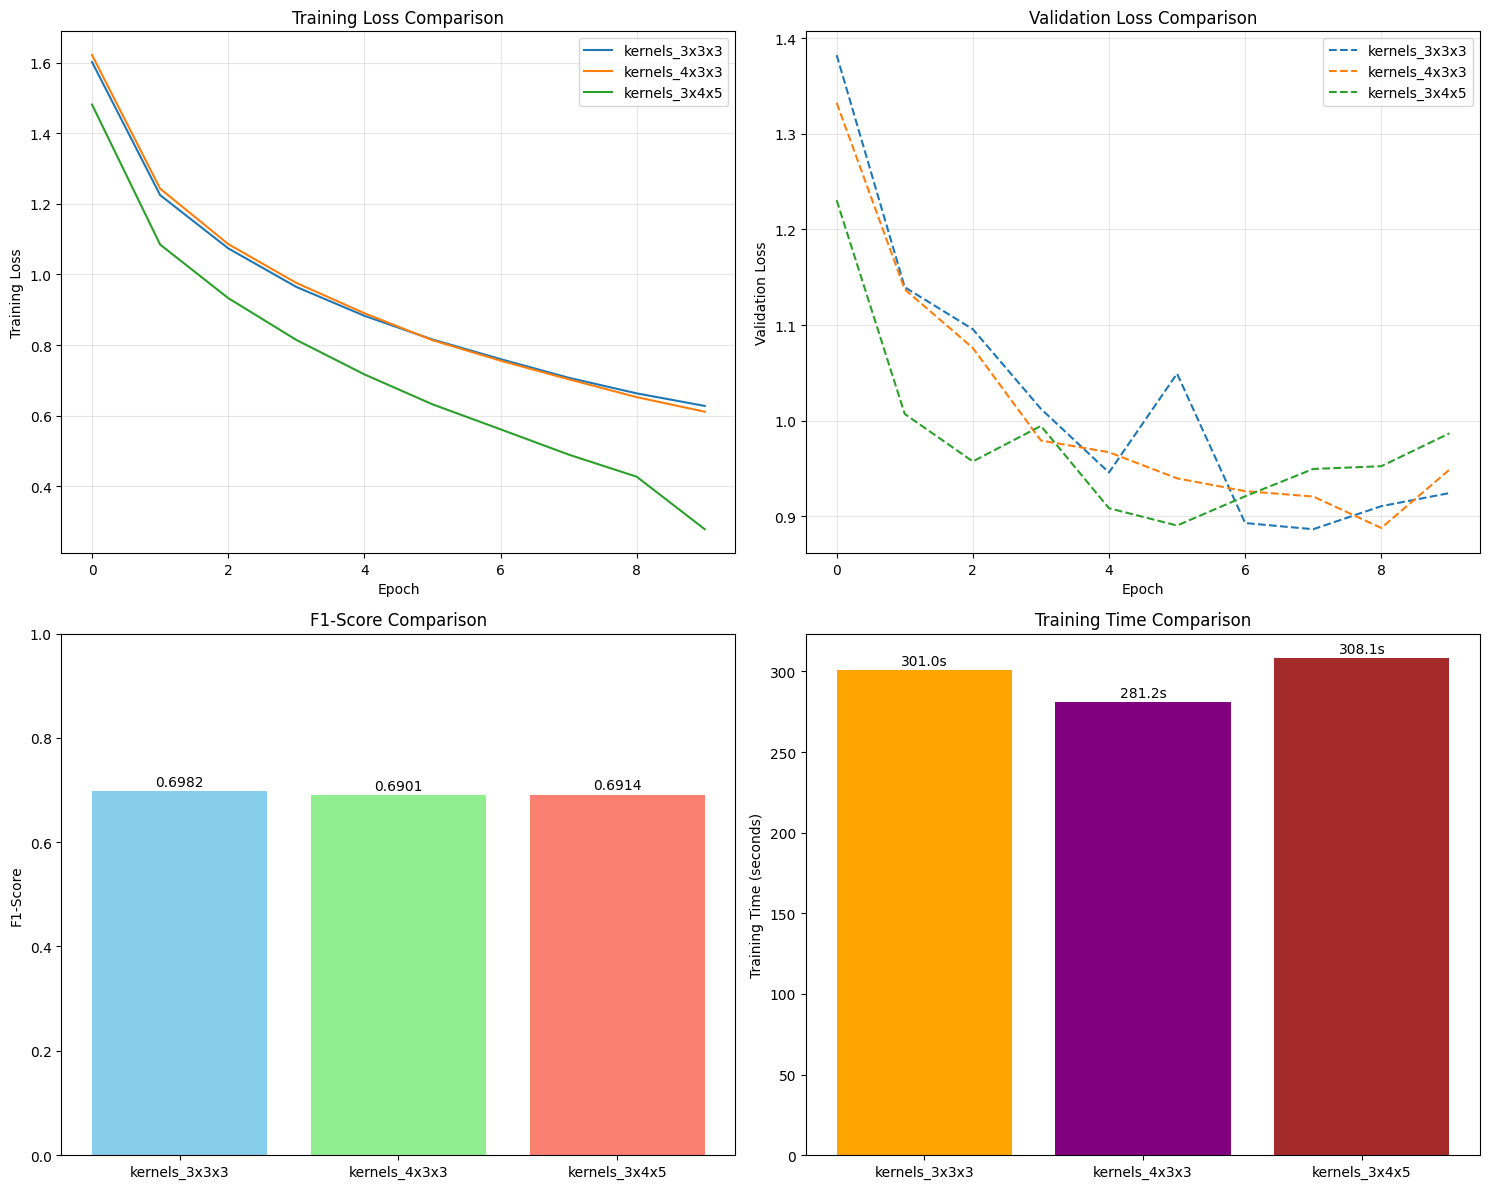


💾 Results saved to: experiment_results/kernel_sizes_experiment_results.csv

EXPERIMENT RESULTS SUMMARY
   Model_Name Kernel_Configuration Test_Accuracy F1_Score Test_Loss Training_Time_seconds
kernels_3x3x3                3x3x3        0.7016   0.6982    0.8953                301.04
kernels_4x3x3                4x3x3        0.6924   0.6901    0.9242                281.23
kernels_3x4x5                3x4x5        0.6950   0.6914    0.9104                308.11

Best Model: kernels_3x3x3
Best F1-Score: 0.6982
Best Accuracy: 0.7016


In [ ]:
def experiment_kernel_sizes():
    """Experiment with different kernel sizes"""
    print("\n" + "="*60)
    print("EXPERIMENT 3: EFFECT OF KERNEL SIZES")
    print("="*60)
    
    # Muat data
    (x_train, y_train), (x_val, y_val), (x_test, y_test), class_names = load_cifar10_data()
    
    # Pengaturan kernel yang akan dieksperimen
    kernel_configs = [
        [3, 3, 3],       # semua kernel 3x3
        [4, 3, 3],       # Dimulai dengan kernel besar, lalu kecil
        [3, 4, 5]        # Ukuran campuran
    ]
    
    models_list = []
    histories = []
    model_names = []
    f1_scores = []
    train_times = []
    accuracies = []
    final_losses = []
    
    os.makedirs('experiment_results', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    
    for i, kernels in enumerate(kernel_configs):
        model_name = f"kernels_{kernels[0]}x{kernels[1]}x{kernels[2]}"
        print(f"\n{'='*50}")
        print(f"Training Model: {model_name}")
        print(f"{'='*50}")
        
        # Gunakan fungsi pembuatan model CNN dengan ukuran kernel yang ditentukan
        model = create_cnn_model(
            conv_layers=3,
            filters_per_layer=[32, 64, 128],
            kernel_sizes=kernels
        )
        
        # Print arsitektur model
        print(f"\nModel Architecture - {model_name}:")
        model.summary()
        
        # Record waktu mulai
        start_time = time.time()
        
        # Latih dan evaluasi model
        trained_model, history, f1_score = train_and_evaluate_model(
            model, x_train, y_train, x_val, y_val, x_test, y_test, 
            model_name, epochs=10
        )
        
        # Record waktu selesai
        end_time = time.time()
        train_time = end_time - start_time

        # Dapatkan akurasi dan loss akhir pada data uji
        test_loss, test_accuracy = trained_model.evaluate(x_test, y_test, verbose=0)
        
        # Simpan hasil
        models_list.append(trained_model)
        histories.append(history)
        model_names.append(model_name)
        f1_scores.append(f1_score)
        train_times.append(train_time)
        accuracies.append(test_accuracy)
        final_losses.append(test_loss)
        
        # Simpan model ke file
        trained_model.save(f'models/cnn_{model_name}.keras')
        
        # Tampilkan kurva training
        print(f"\n📊 Training Curves for {model_name}:")
        plot_individual_training_history(history, model_name)
        
        # Generate dan tampilkan confusion matrix
        test_predictions = trained_model.predict(x_test, verbose=0)
        y_pred = np.argmax(test_predictions, axis=1)
        
        print(f"\n🔍 Confusion Matrix for {model_name}:")
        plot_confusion_matrix(y_test, y_pred, class_names, model_name)
        
        print(f"\nResults for {model_name}:")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1-Score: {f1_score:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Training Time: {train_time:.2f} seconds")
    
    # Tampilkan perbandingan semua model
    print(f"\n📈 Combined Comparison of All Models:")
    plot_combined_comparison(histories, model_names, f1_scores, train_times)
    
    # Simpan hasil ke CSV
    results_df = save_results_to_csv_kernels(
        model_names, accuracies, f1_scores, final_losses, train_times,
        'experiment_results/kernel_sizes_experiment_results.csv'
    )
    
    # Print hasil eksperimen
    print(f"\n{'='*60}")
    print("EXPERIMENT RESULTS SUMMARY")
    print(f"{'='*60}")
    print(results_df.to_string(index=False))
    
    # Print model terbaik berdasarkan F1-Score
    best_f1_idx = np.argmax(f1_scores)
    print(f"\nBest Model: {model_names[best_f1_idx]}")
    print(f"Best F1-Score: {f1_scores[best_f1_idx]:.4f}")
    print(f"Best Accuracy: {accuracies[best_f1_idx]:.4f}")
    
    return models_list, histories, model_names, f1_scores

kernel_models, kernel_histories, kernel_names, kernel_scores = experiment_kernel_sizes()

## 3.4 Eksperimen Jenis Pooling Layer
2 variasi pooling layer:
1. Max Pooling
2. Average Pooling


EXPERIMENT 4: EFFECT OF POOLING LAYER TYPES
Training set: (40000, 32, 32, 3), (40000,)
Validation set: (10000, 32, 32, 3), (10000,)
Test set: (10000, 32, 32, 3), (10000,)

Training Model: max_pooling
After Conv Layer 1, output shape: (None, 30, 30, 32)
After Conv Layer 2, output shape: (None, 13, 13, 64)
After Conv Layer 3, output shape: (None, 4, 4, 128)

Model Architecture - max_pooling:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                          

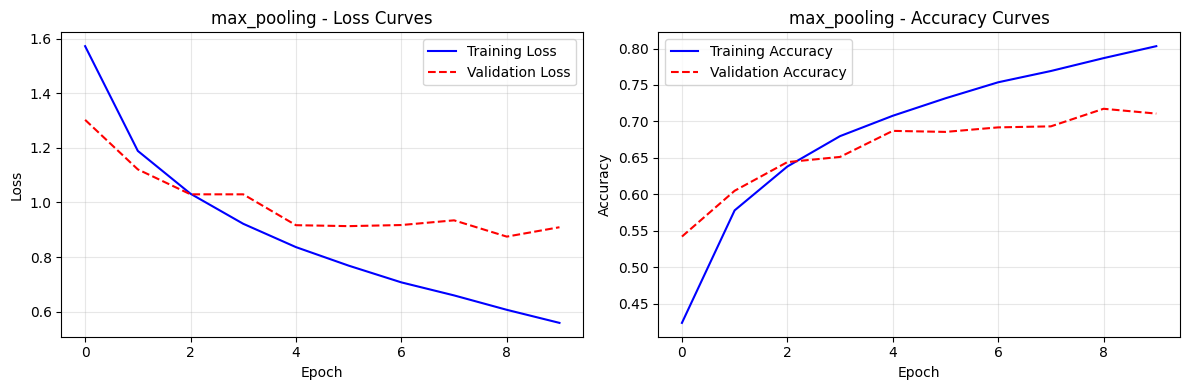


🔍 Confusion Matrix for max_pooling:


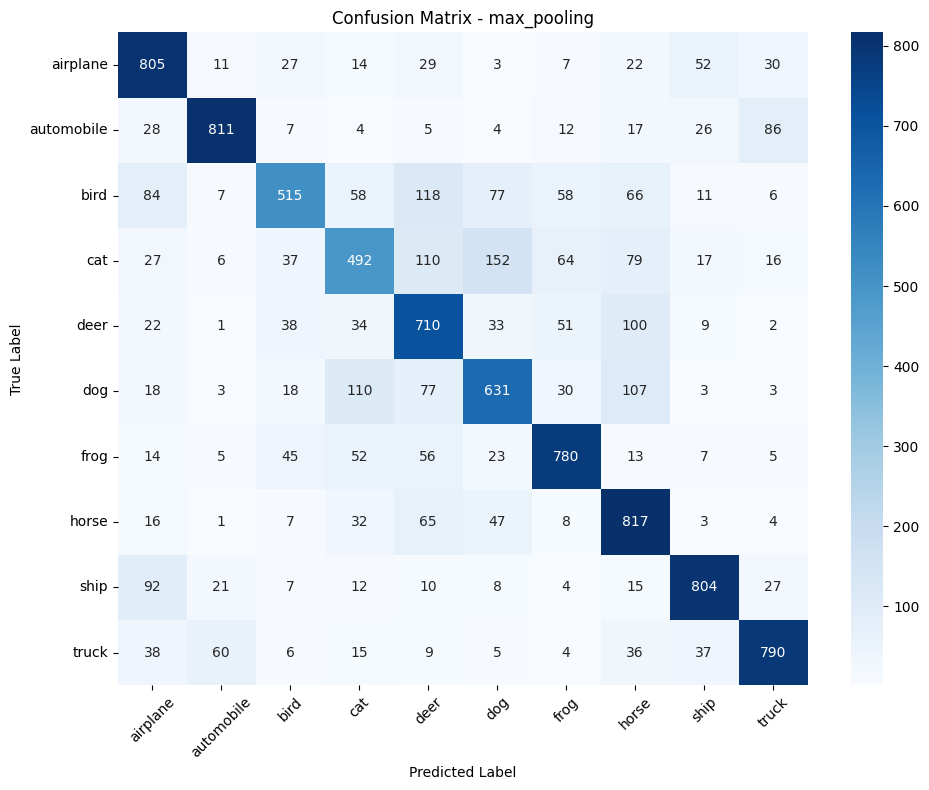


Results for max_pooling:
Test Accuracy: 0.7155
Test F1-Score: 0.7133
Test Loss: 0.8821
Training Time: 308.55 seconds

Training Model: average_pooling
After Conv Layer 1, output shape: (None, 30, 30, 32)
After Conv Layer 2, output shape: (None, 13, 13, 64)
After Conv Layer 3, output shape: (None, 4, 4, 128)

Model Architecture - average_pooling:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 average_pooling2d_1 (Averag  (None, 15, 15, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 average_pooling2d_2 (Averag  (None,

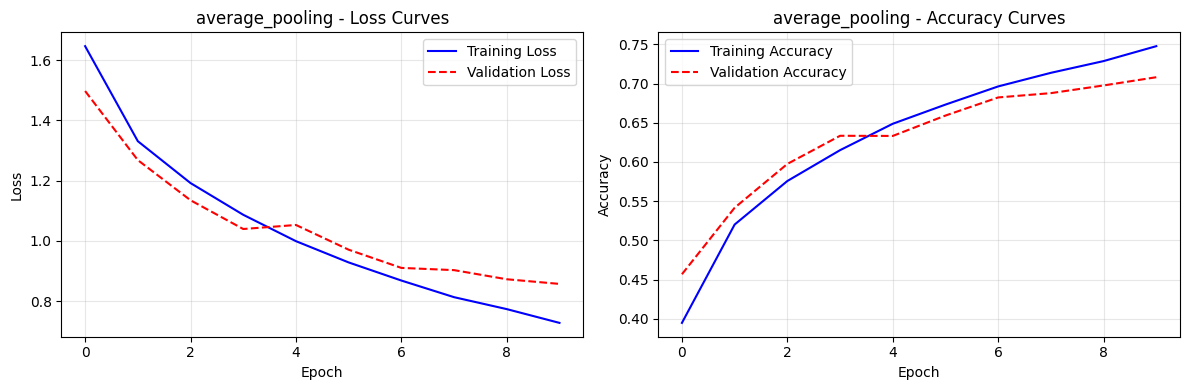


🔍 Confusion Matrix for average_pooling:


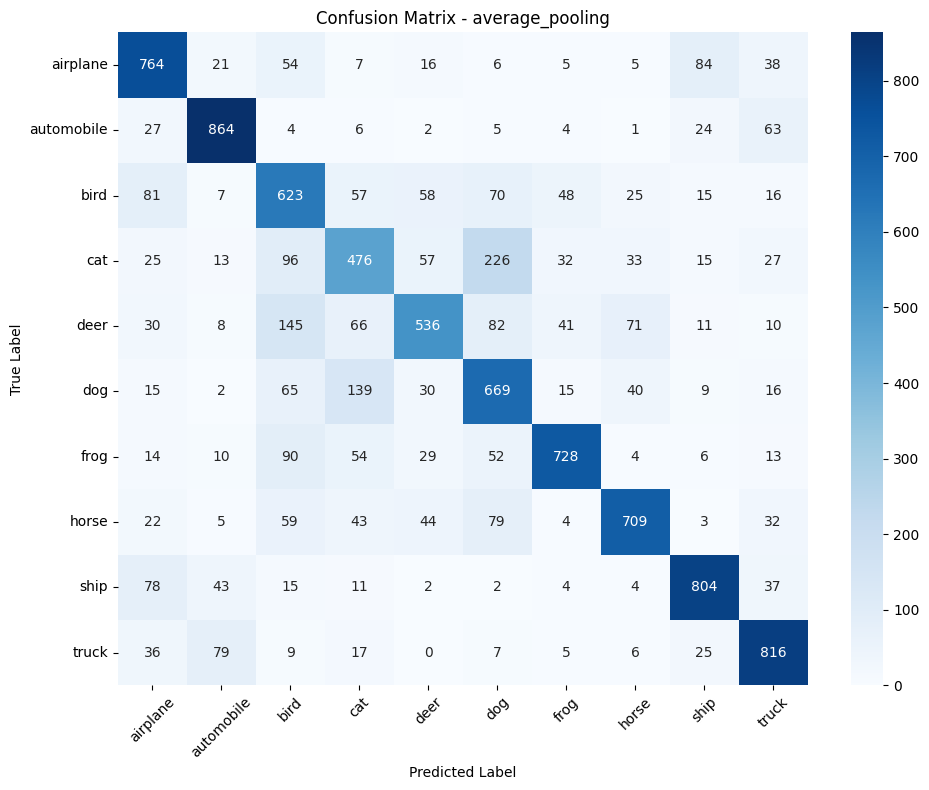


Results for average_pooling:
Test Accuracy: 0.6989
Test F1-Score: 0.6984
Test Loss: 0.8597
Training Time: 291.61 seconds

📈 Combined Comparison of All Models:


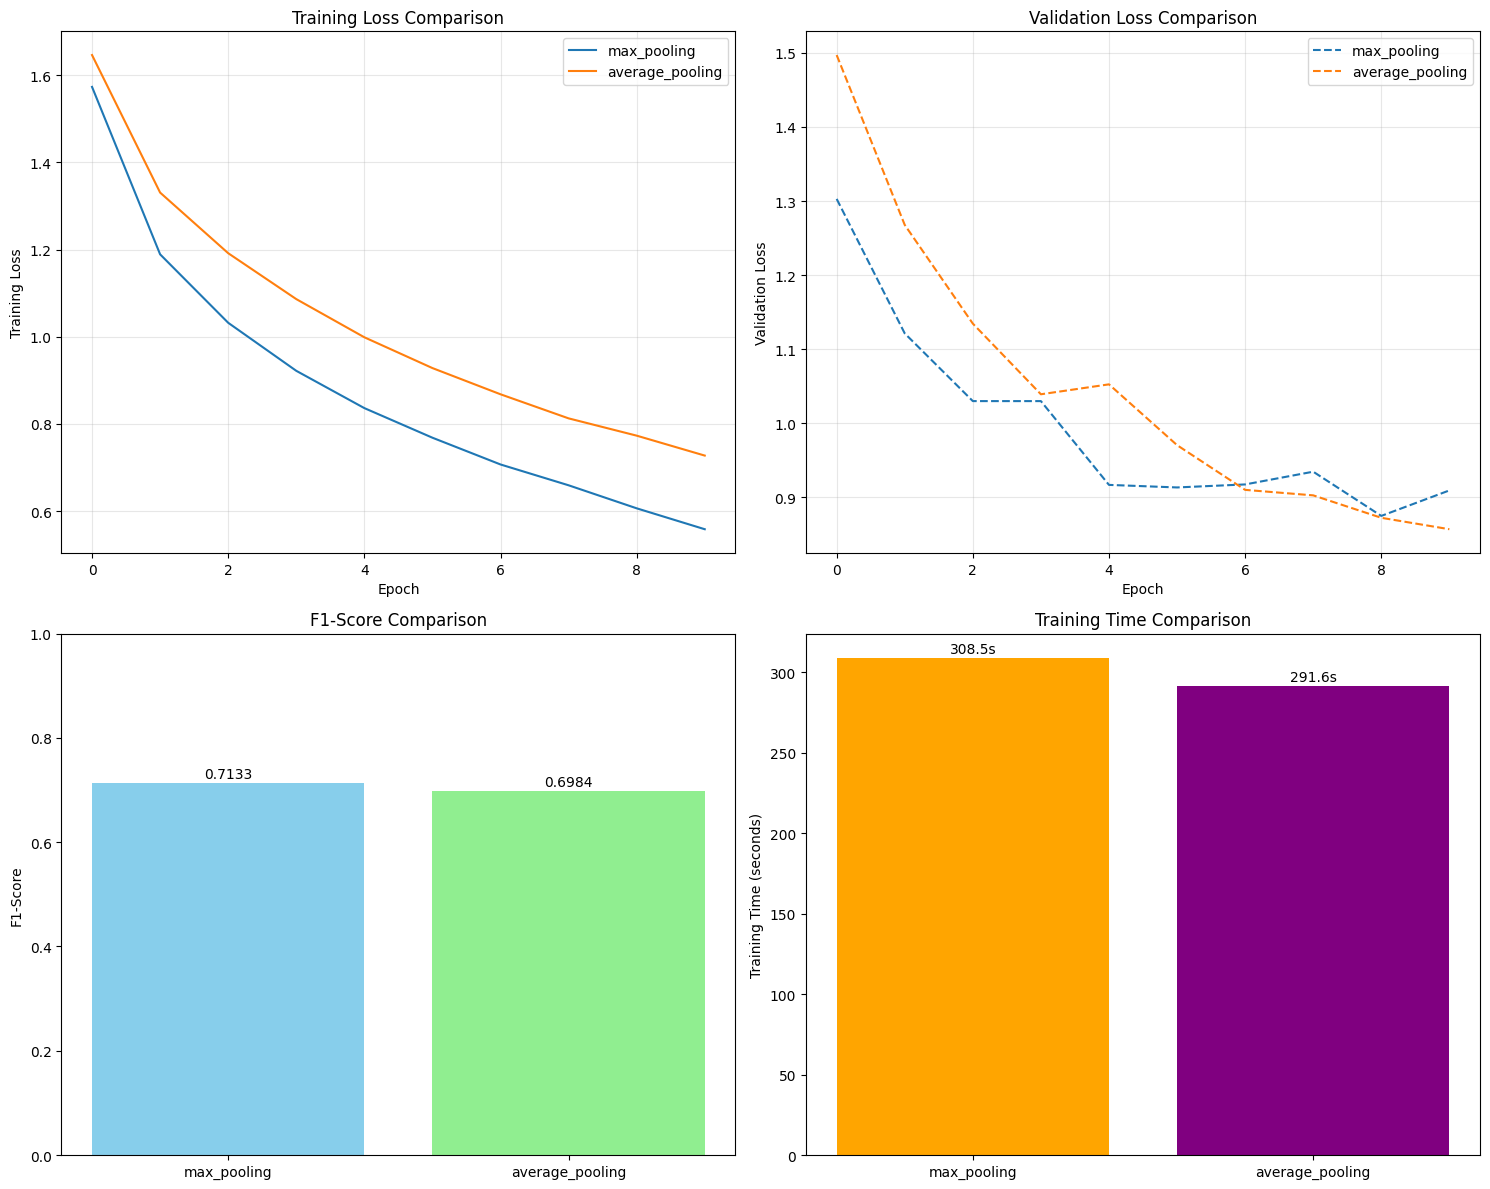


💾 Results saved to: experiment_results/pooling_types_experiment_results.csv

EXPERIMENT RESULTS SUMMARY
     Model_Name Pooling_Type Test_Accuracy F1_Score Test_Loss Training_Time_seconds
    max_pooling          Max        0.7155   0.7133    0.8821                308.55
average_pooling      Average        0.6989   0.6984    0.8597                291.61

Best Model: max_pooling
Best F1-Score: 0.7133
Best Accuracy: 0.7155


In [5]:
def experiment_pooling_types():
    """Experiment with different pooling layer types"""
    print("\n" + "="*60)
    print("EXPERIMENT 4: EFFECT OF POOLING LAYER TYPES")
    print("="*60)
    
    # Muat data
    (x_train, y_train), (x_val, y_val), (x_test, y_test), class_names = load_cifar10_data()
    
    # Jenis pooling yang akan dieksperimen
    pooling_types = ['max','average']
    
    models_list = []
    histories = []
    model_names = []
    f1_scores = []
    train_times = []
    accuracies = []
    final_losses = []
    
    os.makedirs('experiment_results', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    
    for pooling_type in pooling_types:
        model_name = f"{pooling_type}_pooling"
        print(f"\n{'='*50}")
        print(f"Training Model: {model_name}")
        print(f"{'='*50}")
        
        # Gunakan fungsi pembuatan model CNN dengan jenis pooling yang ditentukan
        model = create_cnn_model(
            conv_layers=3,
            filters_per_layer=[32, 64, 128],
            kernel_sizes=[3, 3, 3],
            pooling_type=pooling_type
        )
        
        # Print arsitektur model
        print(f"\nModel Architecture - {model_name}:")
        model.summary()
        
        # Record waktu mulai
        start_time = time.time()
        
        # Train dan evaluasi model
        trained_model, history, f1_score = train_and_evaluate_model(
            model, x_train, y_train, x_val, y_val, x_test, y_test, 
            model_name, epochs=10
        )
        
        # Record waktu selesai
        end_time = time.time()
        train_time = end_time - start_time
        
        # Dapatkan akurasi dan loss akhir pada data uji
        test_loss, test_accuracy = trained_model.evaluate(x_test, y_test, verbose=0)
        
        # Save results
        models_list.append(trained_model)
        histories.append(history)
        model_names.append(model_name)
        f1_scores.append(f1_score)
        train_times.append(train_time)
        accuracies.append(test_accuracy)
        final_losses.append(test_loss)
        
        # Simpan model ke file
        trained_model.save(f'models/cnn_{model_name}.keras')
        
        # Plot kurva training
        print(f"\n📊 Training Curves for {model_name}:")
        plot_individual_training_history(history, model_name)
        
        # Generate dan tampilkan confusion matrix
        test_predictions = trained_model.predict(x_test, verbose=0)
        y_pred = np.argmax(test_predictions, axis=1)
        
        print(f"\n🔍 Confusion Matrix for {model_name}:")
        plot_confusion_matrix(y_test, y_pred, class_names, model_name)
        
        print(f"\nResults for {model_name}:")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1-Score: {f1_score:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Training Time: {train_time:.2f} seconds")

    # Tampilkan perbandingan semua model
    print(f"\n📈 Combined Comparison of All Models:")
    plot_combined_comparison(histories, model_names, f1_scores, train_times)
    
    # Simpan hasil ke CSV
    results_df = save_results_to_csv_pooling(
        model_names, accuracies, f1_scores, final_losses, train_times,
        'experiment_results/pooling_types_experiment_results.csv'
    )
    
    # Print hasil eksperimen
    print(f"\n{'='*60}")
    print("EXPERIMENT RESULTS SUMMARY")
    print(f"{'='*60}")
    print(results_df.to_string(index=False))
    
    # Print model terbaik berdasarkan F1-Score
    best_f1_idx = np.argmax(f1_scores)
    print(f"\nBest Model: {model_names[best_f1_idx]}")
    print(f"Best F1-Score: {f1_scores[best_f1_idx]:.4f}")
    print(f"Best Accuracy: {accuracies[best_f1_idx]:.4f}")
    
    return models_list, histories, model_names, f1_scores

pooling_models, pooling_histories, pooling_names, pooling_scores = experiment_pooling_types()

# 4. Implementasi Forward Propagation dari Awal (From Scratch)
Di sini kita mengimplementasikan forward propagation dari awal menggunakan NumPy dan membandingkannya dengan implementasi Keras.

## 4.1 Pengujian Forward Propagation pada Model Optimal untuk Variasi Layer Konvolusi

In [7]:
# Baca file CSV
file_path = "experiment_results/conv_layers_experiment_results.csv"
data = pd.read_csv(file_path)

# Cari baris dengan nilai f1_score tertinggi
best_configuration = data.loc[data['f1_score'].idxmax()]

# Cetak konfigurasi terbaik
print("Konfigurasi Terbaik Berdasarkan F1 Score:")
print(best_configuration)

Konfigurasi Terbaik Berdasarkan F1 Score:
num_layers      3.000000
accuracy        0.686800
f1_score        0.685485
loss            0.925977
train_time    318.266408
Name: 2, dtype: float64



CNN FROM SCRATCH IMPLEMENTATION
Training set: (40000, 32, 32, 3), (40000,)
Validation set: (10000, 32, 32, 3), (10000,)
Test set: (10000, 32, 32, 3), (10000,)
Loaded test data: 10000 samples
Image shape: (32, 32, 3)
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Loading Keras model from: models/cnn_3_layers.keras
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                       

c:\Users\aland\Desktop\IF3270_Tubes2_62\src\cnn\from_scratch.py:680: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


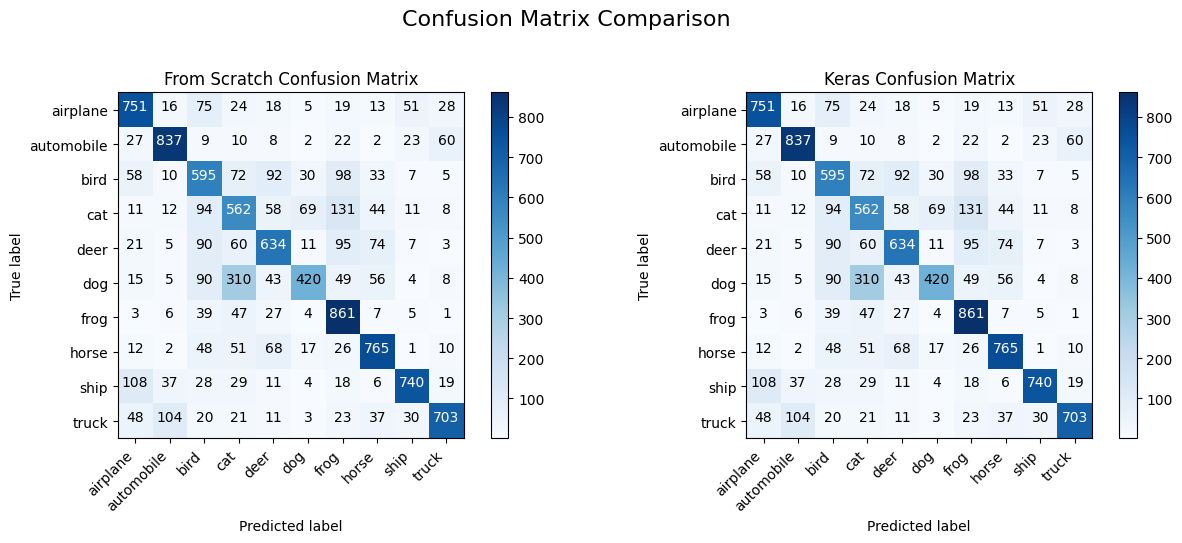

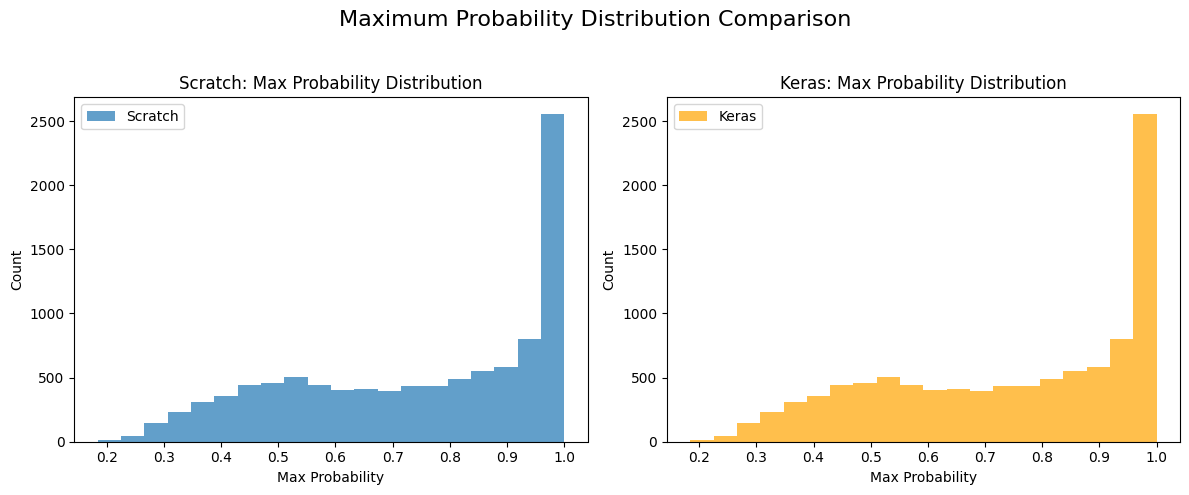

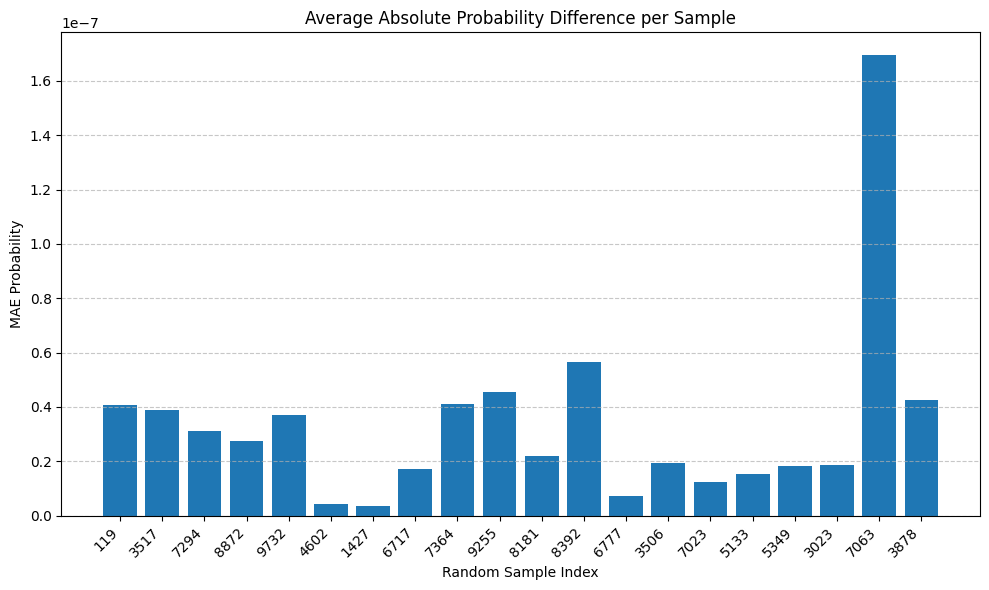

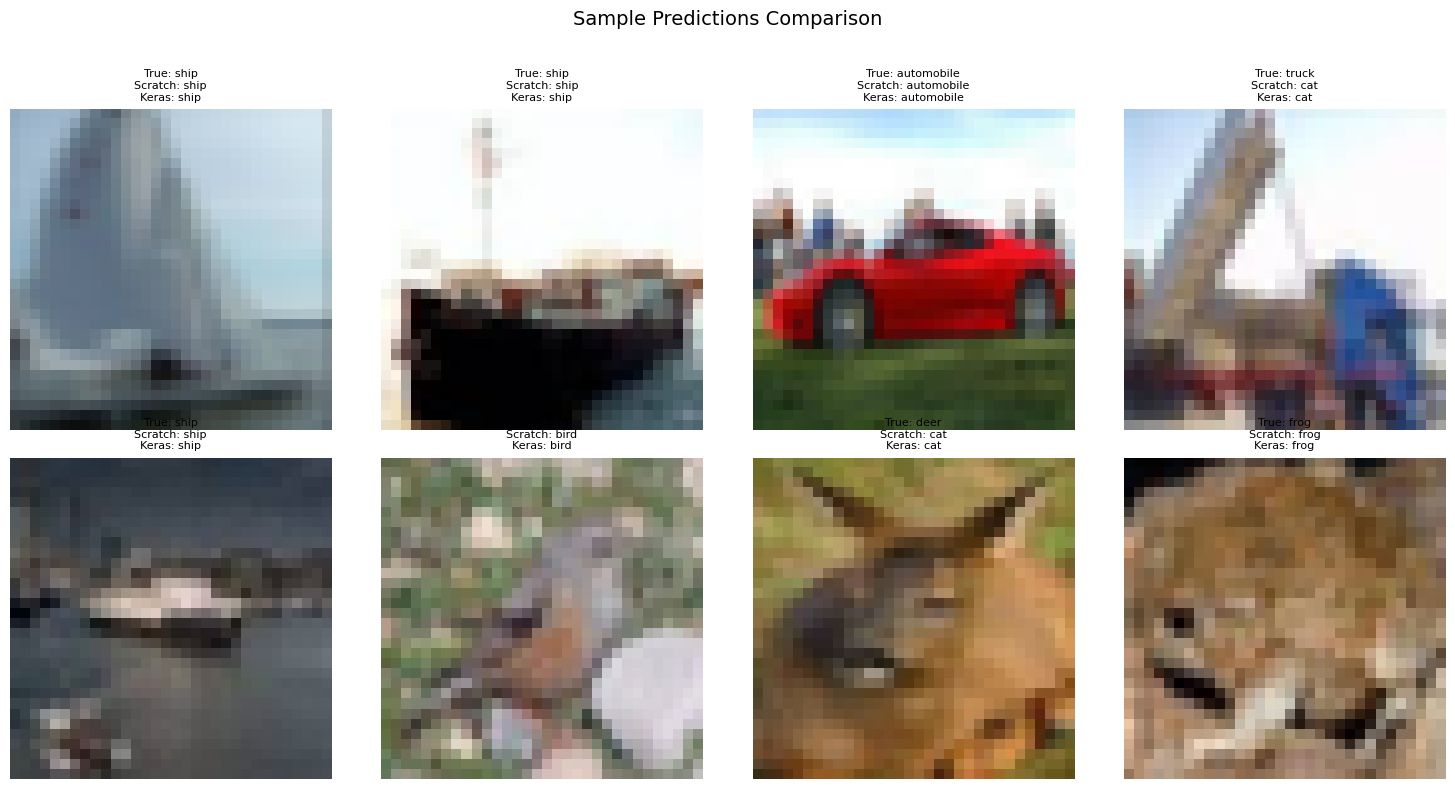

In [2]:
run_from_scratch_comparison("models/cnn_3_layers.keras")

## 4.2 Pengujian Forward Propagation pada Model Optimal untuk Variasi Banyak Filter per Layer Konvolusi

In [3]:
# Baca file CSV
file_path = "experiment_results/filter_numbers_experiment_results.csv"
data = pd.read_csv(file_path)

# Cari baris dengan nilai f1_score tertinggi
best_configuration = data.loc[data['f1_score'].idxmax()]

# Cetak konfigurasi terbaik
print("Konfigurasi Terbaik Berdasarkan F1 Score:")
print(best_configuration)

Konfigurasi Terbaik Berdasarkan F1 Score:
filter_config     32-64-128
accuracy             0.7206
f1_score           0.720639
loss               0.888435
train_time       280.319793
Name: 1, dtype: object



CNN FROM SCRATCH IMPLEMENTATION
Training set: (40000, 32, 32, 3), (40000,)
Validation set: (10000, 32, 32, 3), (10000,)
Test set: (10000, 32, 32, 3), (10000,)
Loaded test data: 10000 samples
Image shape: (32, 32, 3)
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Loading Keras model from: models/cnn_filters_32_64_128.keras
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                              

c:\Users\aland\Desktop\IF3270_Tubes2_62\src\cnn\from_scratch.py:680: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


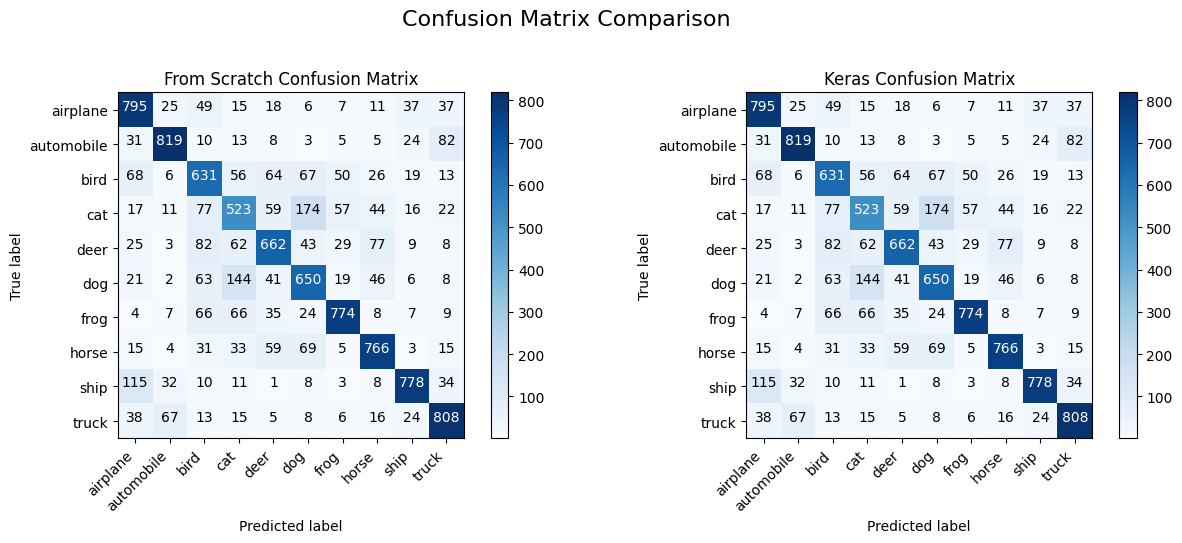

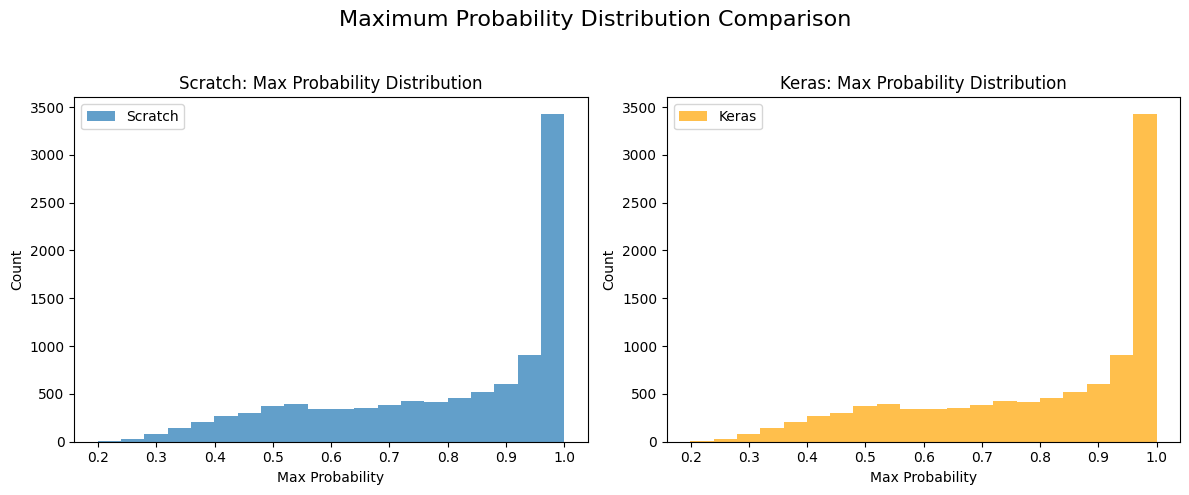

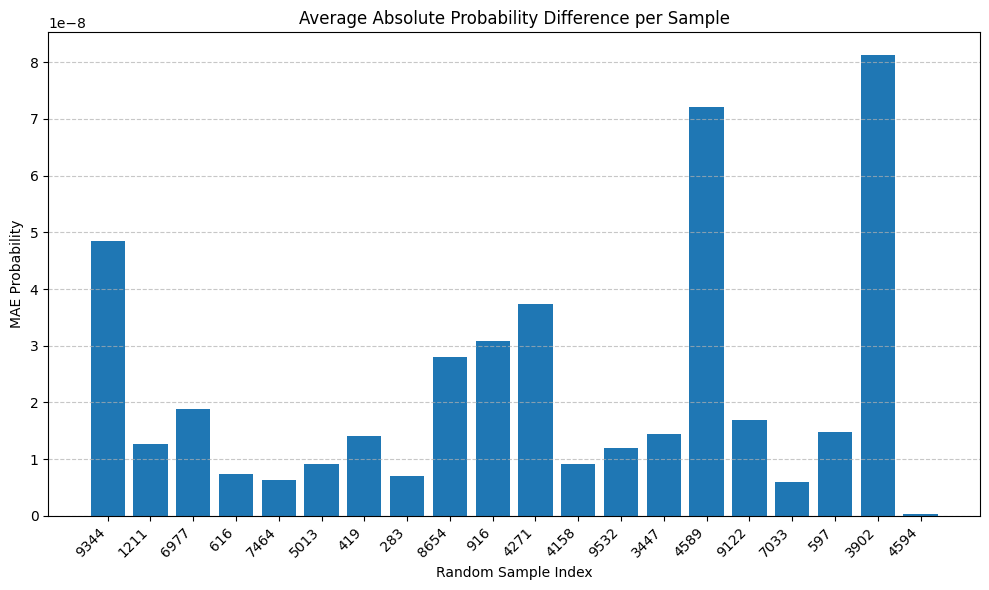

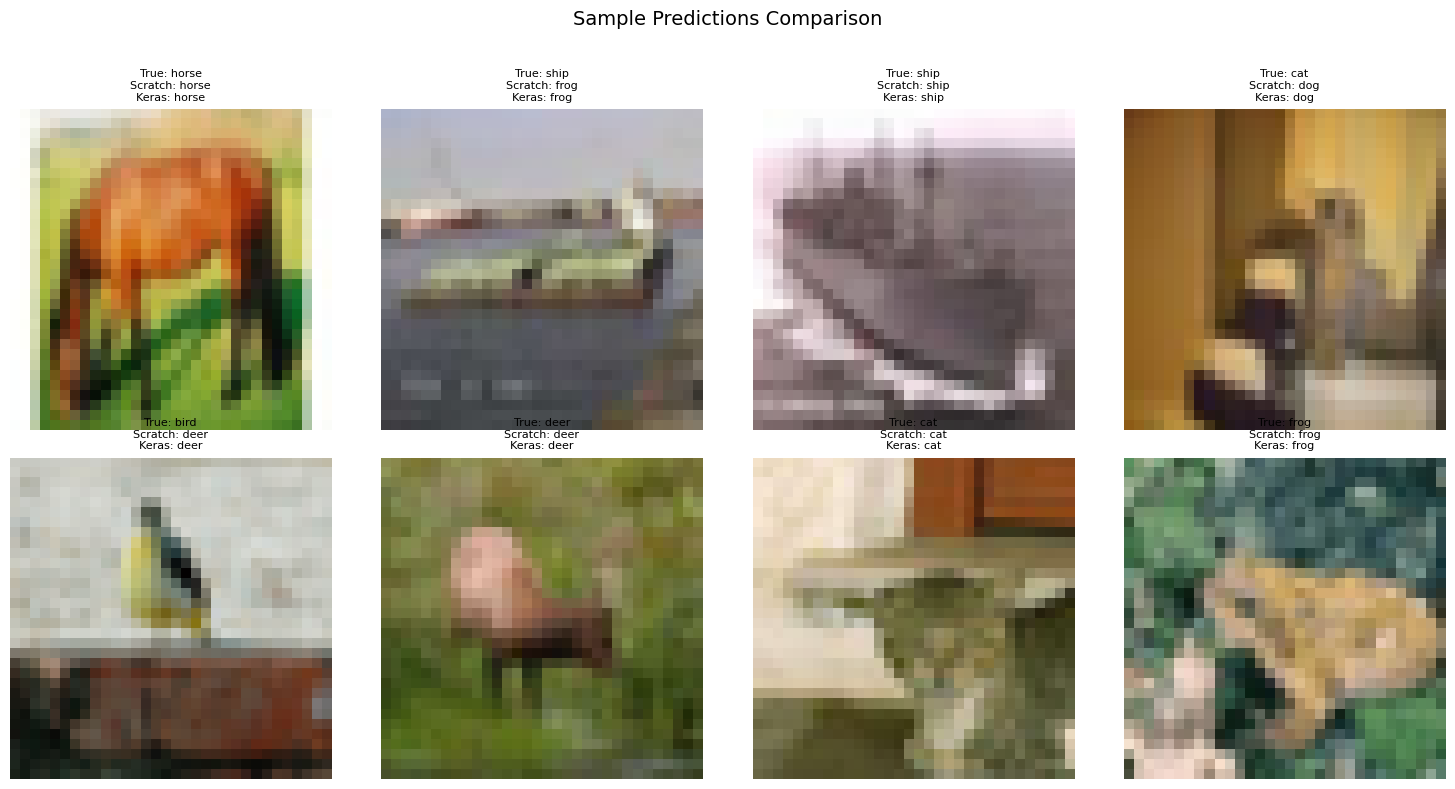

In [4]:
run_from_scratch_comparison("models/cnn_filters_32_64_128.keras")

## 4.3 Pengujian Forward Propagation pada Model Optimal untuk Variasi Ukuran Filter per Layer Konvolusi

In [6]:
# Baca file CSV
file_path = "experiment_results/kernel_sizes_experiment_results.csv"
data = pd.read_csv(file_path)

# Cari baris dengan nilai f1_score tertinggi
best_configuration = data.loc[data['F1_Score'].idxmax()]

# Cetak konfigurasi terbaik
print("Konfigurasi Terbaik Berdasarkan F1 Score:")
print(best_configuration)

Konfigurasi Terbaik Berdasarkan F1 Score:
Model_Name               kernels_3x3x3
Kernel_Configuration             3x3x3
Test_Accuracy                   0.7016
F1_Score                        0.6982
Test_Loss                       0.8953
Training_Time_seconds           301.04
Name: 0, dtype: object



CNN FROM SCRATCH IMPLEMENTATION
Training set: (40000, 32, 32, 3), (40000,)
Validation set: (10000, 32, 32, 3), (10000,)
Test set: (10000, 32, 32, 3), (10000,)
Loaded test data: 10000 samples
Image shape: (32, 32, 3)
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Loading Keras model from: models/cnn_kernels_3x3x3.keras
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                  

c:\Users\aland\Desktop\IF3270_Tubes2_62\src\cnn\from_scratch.py:680: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


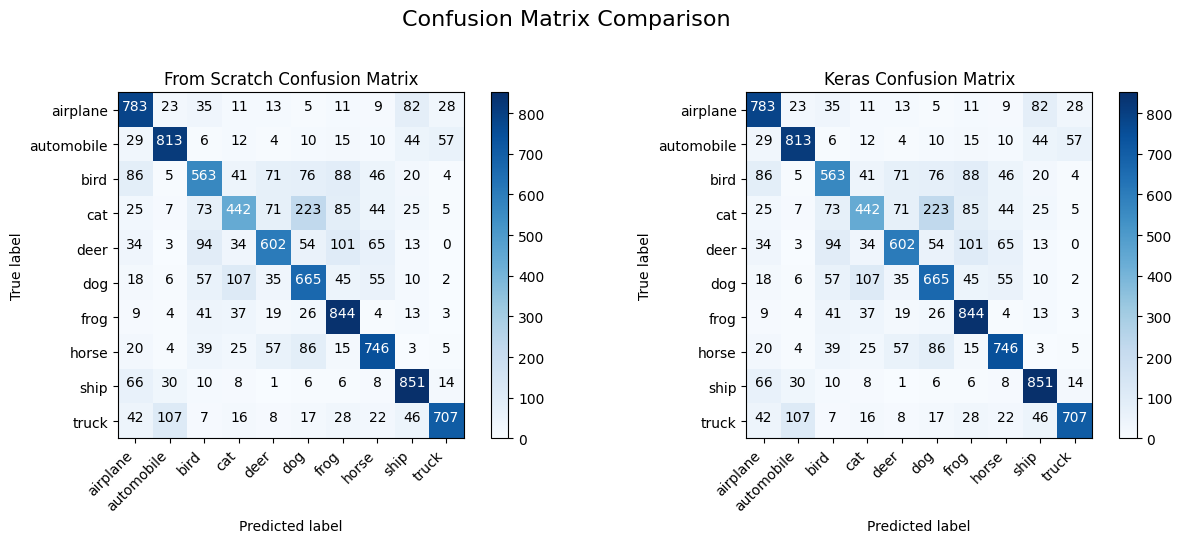

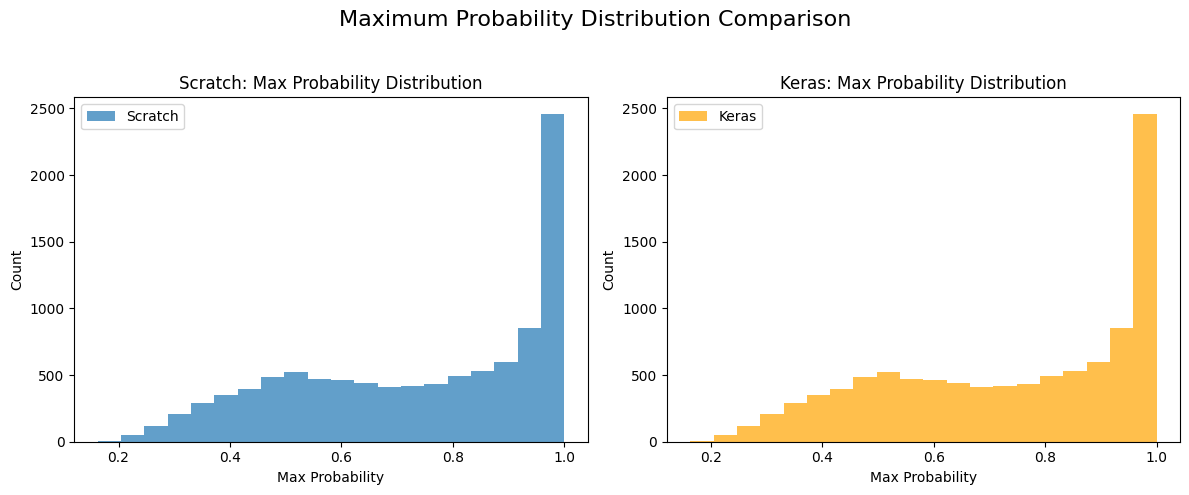

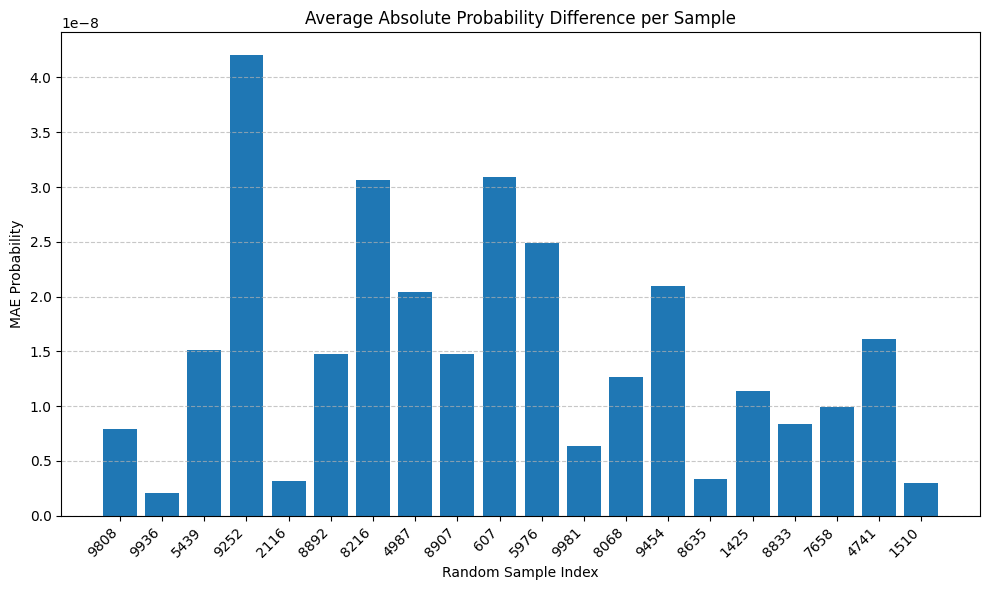

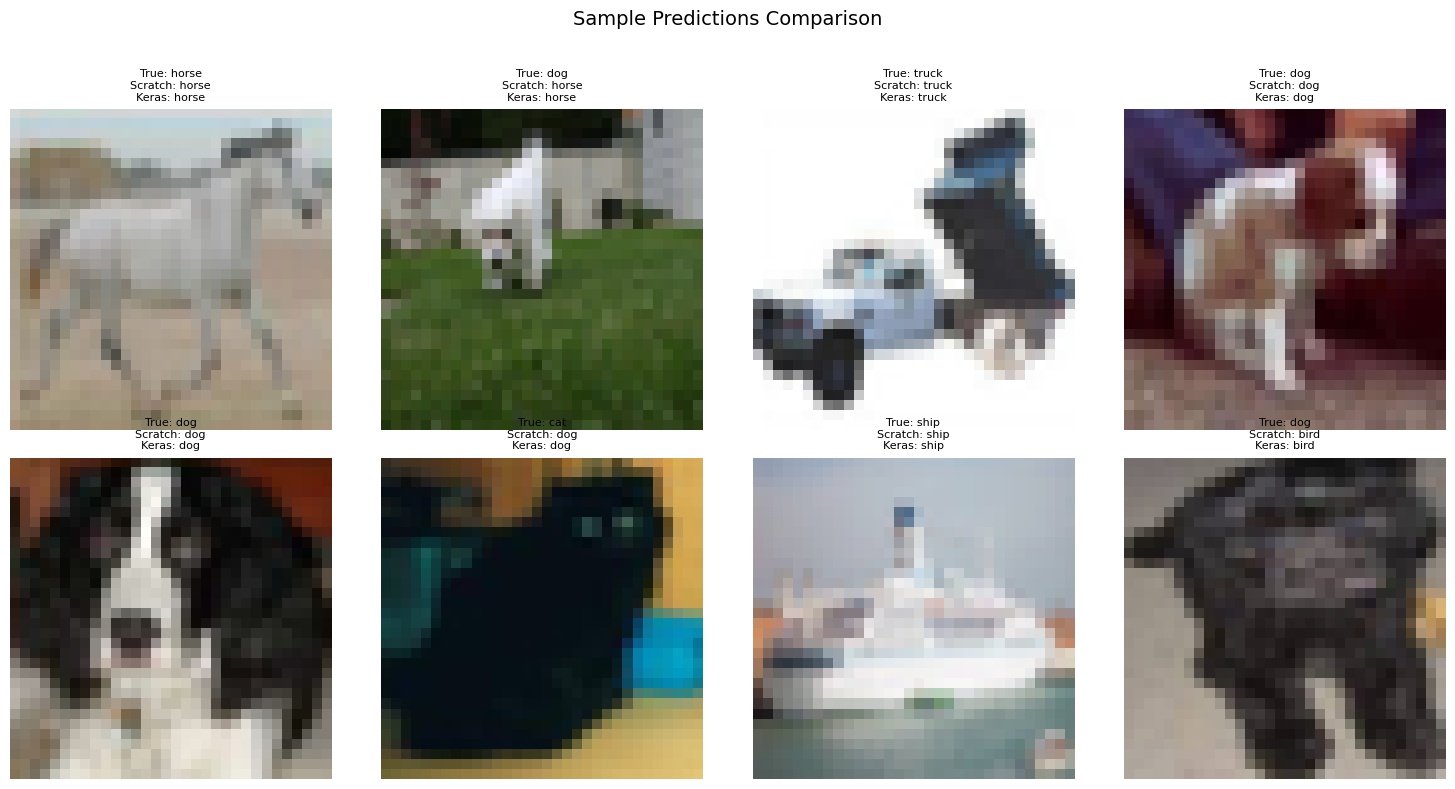

In [7]:
run_from_scratch_comparison("models/cnn_kernels_3x3x3.keras")

## 4.4 Pengujian Forward Propagation pada Model Optimal untuk Variasi Jenis Pooling Layer

In [9]:
# Baca file CSV
file_path = "experiment_results/pooling_types_experiment_results.csv"
data = pd.read_csv(file_path)

# Cari baris dengan nilai f1_score tertinggi
best_configuration = data.loc[data['F1_Score'].idxmax()]

# Cetak konfigurasi terbaik
print("Konfigurasi Terbaik Berdasarkan F1 Score:")
print(best_configuration)

Konfigurasi Terbaik Berdasarkan F1 Score:
Model_Name               max_pooling
Pooling_Type                     Max
Test_Accuracy                 0.7155
F1_Score                      0.7133
Test_Loss                     0.8821
Training_Time_seconds         308.55
Name: 0, dtype: object



CNN FROM SCRATCH IMPLEMENTATION
Training set: (40000, 32, 32, 3), (40000,)
Validation set: (10000, 32, 32, 3), (10000,)
Test set: (10000, 32, 32, 3), (10000,)
Loaded test data: 10000 samples
Image shape: (32, 32, 3)
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Loading Keras model from: models/cnn_max_pooling.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                      

c:\Users\aland\Desktop\IF3270_Tubes2_62\src\cnn\from_scratch.py:680: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


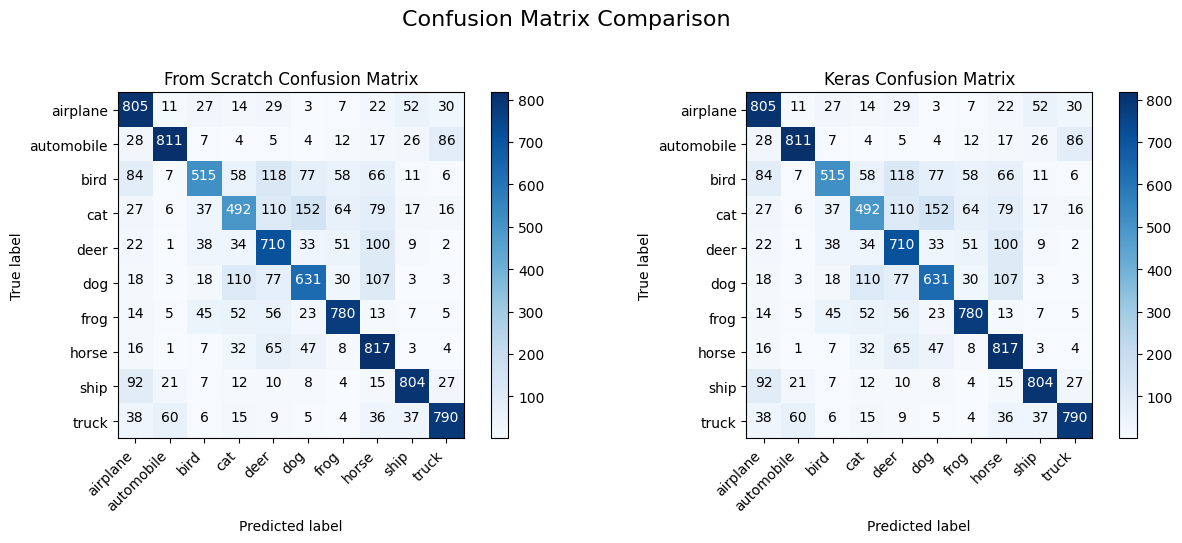

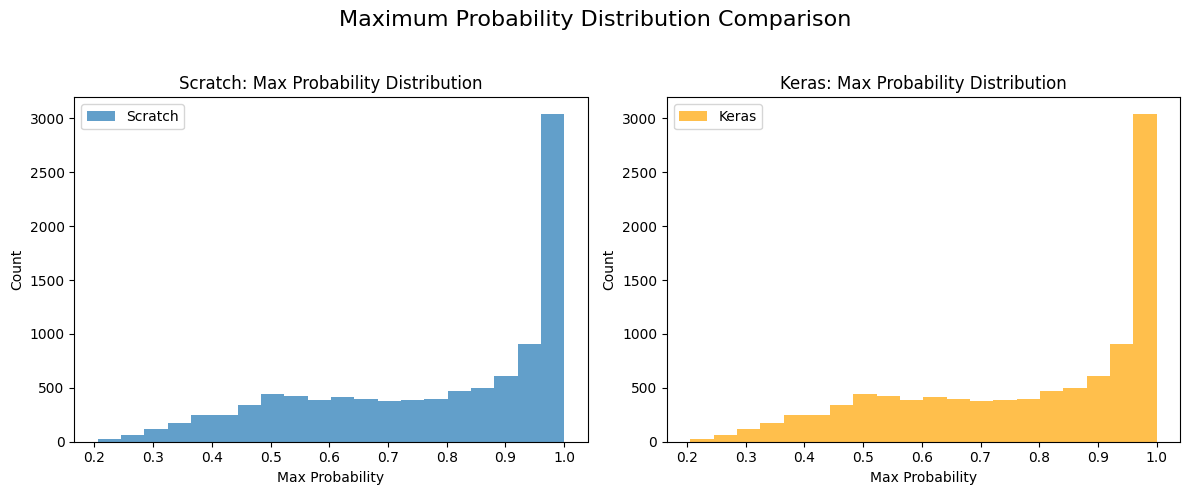

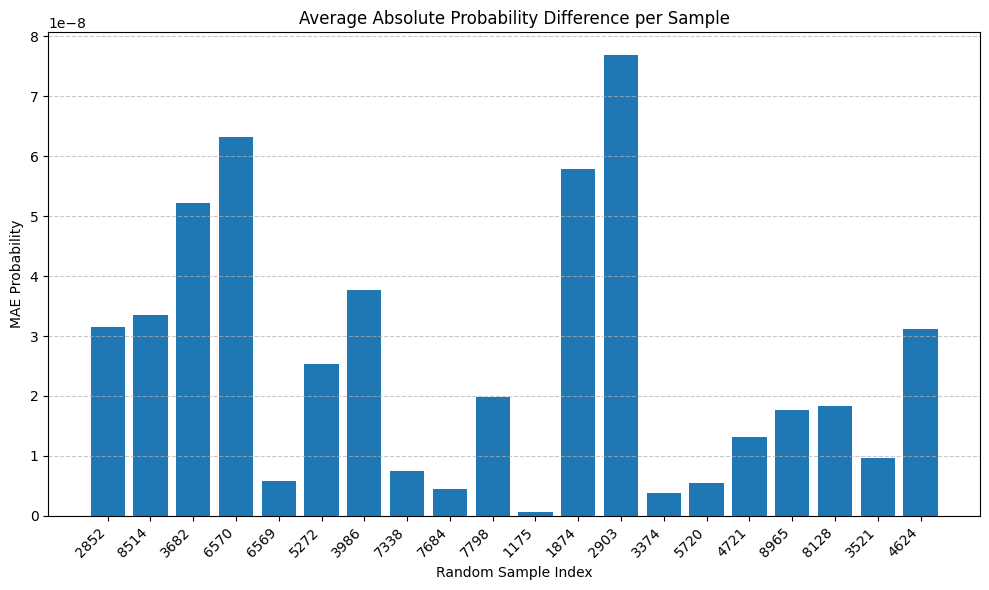

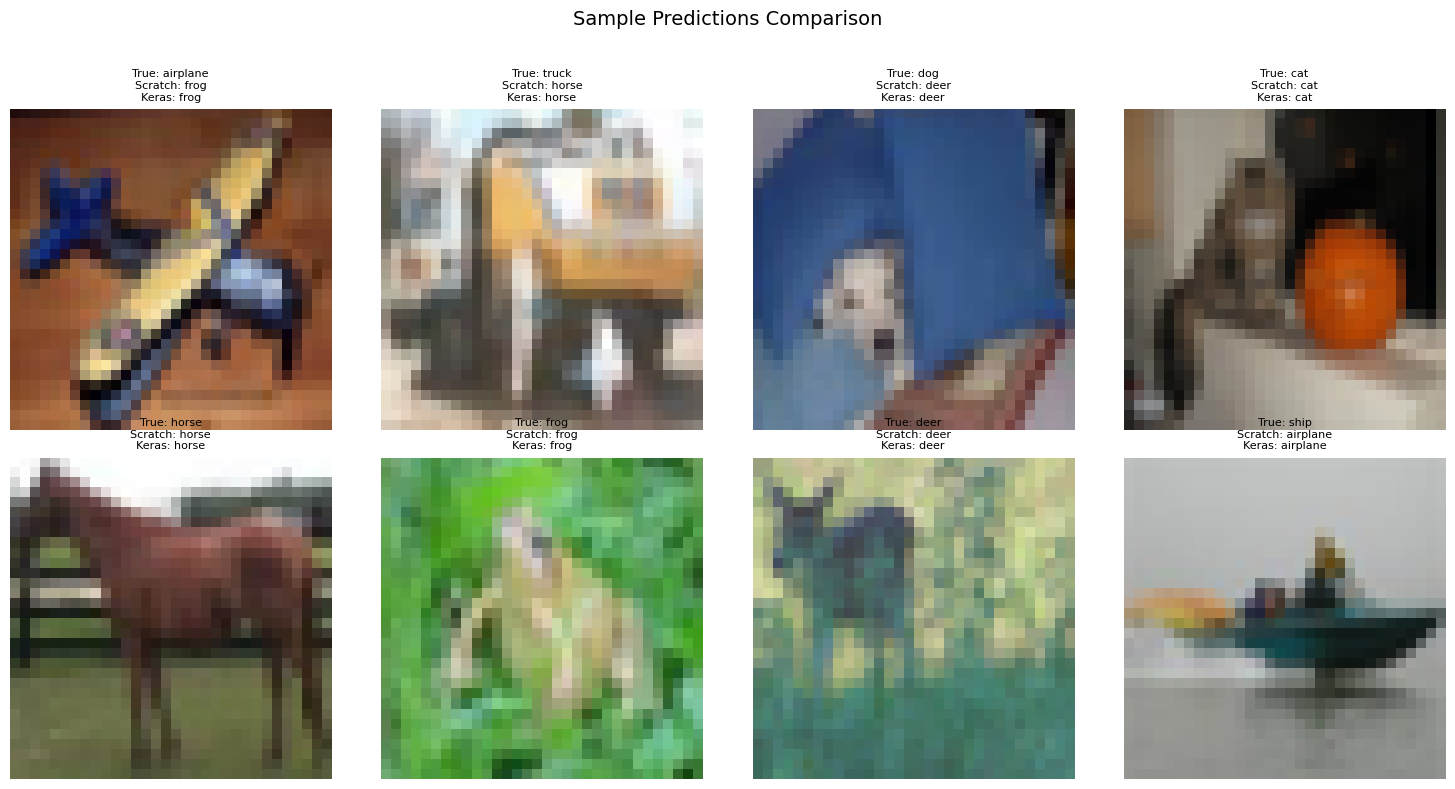

In [10]:
run_from_scratch_comparison("models/cnn_max_pooling.keras")